In [2]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as pl
import seaborn           as sns
import tensorflow        as tf

import re
import json

from functools        import partial
from itertools        import filterfalse
from wordcloud        import WordCloud
from tensorflow       import keras
from tensorflow.keras import layers

%matplotlib inline

# Data Preparation and Cleaning

Also availble at: [data.world ted talk data](https://data.world/owentemple/ted-talks-complete-list/workspace/file?filename=TED_Talks_by_ID_plus-transcripts-and-LIWC-and-MFT-plus-views.csv)

In [4]:
!wget --output-document=data.csv https://query.data.world/s/pou2lvcbdyedfsckaqapj7mfjypvi6

In [5]:
df = pd.read_csv('data.csv')
df.head()

,id,speaker,headline,URL,description,transcript_URL,month_filmed,year_filmed,event,duration,...,harm_vice,fairness_virtue,fairness_vice,ingroup_virtue,ingroup_vice,authority_virtue,authority_vice,purity_virtue,purity_vice,morality_general
0,1,Al Gore,Averting the climate crisis,http://www.ted.com/talks/view/id/1,With the same humor and humanity he exuded in ...,http://www.ted.com/talks/view/id/1/transcript?...,2,2006,TED2006,0:16:17,...,0.04,0.00,0.00,0.48,0.00,0.22,0.0,0.00,0.00,0.22
1,2,Amy Smith,Simple designs to save a life,http://www.ted.com/talks/view/id/2,Fumes from indoor cooking fires kill more than...,http://www.ted.com/talks/view/id/2/transcript?...,2,2006,TED2006,0:15:06,...,0.04,0.00,0.00,0.30,0.00,0.11,0.0,0.11,0.04,0.15
2,3,Ashraf Ghani,How to rebuild a broken state,http://www.ted.com/talks/view/id/3,Ashraf Ghani's passionate and powerful 10-minu...,http://www.ted.com/talks/view/id/3/transcript?...,7,2005,TEDGlobal 2005,0:18:45,...,0.12,0.16,0.04,0.32,0.12,0.20,0.0,0.04,0.04,0.08
3,4,Burt Rutan,The real future of space exploration,http://www.ted.com/talks/view/id/4,"In this passionate talk, legendary spacecraft ...",http://www.ted.com/talks/view/id/4/transcript?...,2,2006,TED2006,0:19:37,...,0.19,0.00,0.00,0.19,0.00,0.10,0.0,0.00,0.00,0.16
4,5,Chris Bangle,Great cars are great art,http://www.ted.com/talks/view/id/5,American designer Chris Bangle explains his ph...,http://www.ted.com/talks/view/id/5/transcript?...,2,2002,TED2002,0:20:04,...,0.05,0.03,0.00,0.39,0.00,0.05,0.0,0.00,0.03,0.13


In [6]:
df.columns.to_list()

['id',
 'speaker',
 'headline',
 'URL',
 'description',
 'transcript_URL',
 'month_filmed',
 'year_filmed',
 'event',
 'duration',
 'date_published',
 'views_as_of_06162017',
 'tags',
 'transcript',
 'notes',
 'WC',
 'Analytic',
 'Clout',
 'Authentic',
 'Tone',
 'WPS',
 'Sixltr',
 'Dic',
 'function',
 'pronoun',
 'ppron',
 'i',
 'we',
 'you',
 'shehe',
 'they',
 'ipron',
 'article',
 'prep',
 'auxverb',
 'adverb',
 'conj',
 'negate',
 'verb',
 'adj',
 'compare',
 'interrog',
 'number',
 'quant',
 'affect',
 'posemo',
 'negemo',
 'anx',
 'anger',
 'sad',
 'social',
 'family',
 'friend',
 'female',
 'male',
 'cogproc',
 'insight',
 'cause',
 'discrep',
 'tentat',
 'certain',
 'differ',
 'percept',
 'see',
 'hear',
 'feel',
 'bio',
 'body',
 'health',
 'sexual',
 'ingest',
 'drives',
 'affiliation',
 'achieve',
 'power',
 'reward',
 'risk',
 'focuspast',
 'focuspresent',
 'focusfuture',
 'relativ',
 'motion',
 'space',
 'time',
 'work',
 'leisure',
 'home',
 'money',
 'relig',
 'death',
 

The data contains some analysed columns, however we are interested in the raw transcripts and meta data from TED.com

In [7]:
columns = ['speaker','headline','description','event','duration','date_published','views_as_of_06162017','tags','transcript']
df = df[columns]
df['duration'] = pd.to_timedelta(df['duration']).dt.total_seconds()
df['date_published'] = pd.to_datetime(df['date_published'])
df = df.rename(columns={'views_as_of_06162017':'views'})
df

,speaker,headline,description,event,duration,date_published,views,tags,transcript
0,Al Gore,Averting the climate crisis,With the same humor and humanity he exuded in ...,TED2006,977.0,2006-06-27,3177001.0,"cars,alternative energy,culture,politics,scien...","0:14\r\r\rThank you so much, Chris.\rAnd it's ..."
1,Amy Smith,Simple designs to save a life,Fumes from indoor cooking fires kill more than...,TED2006,906.0,2006-08-15,1379328.0,"MacArthur grant,simplicity,industrial design,a...","0:11\r\r\rIn terms of invention,\rI'd like to ..."
2,Ashraf Ghani,How to rebuild a broken state,Ashraf Ghani's passionate and powerful 10-minu...,TEDGlobal 2005,1125.0,2006-10-18,790536.0,"corruption,poverty,economics,investment,milita...","0:12\r\r\rA public, Dewey long ago observed,\r..."
3,Burt Rutan,The real future of space exploration,"In this passionate talk, legendary spacecraft ...",TED2006,1177.0,2006-10-25,1985119.0,"aircraft,flight,industrial design,NASA,rocket ...","0:11\r\r\rI want to start off by saying, Houst..."
4,Chris Bangle,Great cars are great art,American designer Chris Bangle explains his ph...,TED2002,1204.0,2007-04-05,859487.0,"cars,industrial design,transportation,inventio...","0:12\r\r\rWhat I want to talk about is, as bac..."
...,...,...,...,...,...,...,...,...,...
2470,Justin Davidson,Why glass towers are bad for city life -- and ...,There's a creepy transformation taking over ou...,TEDNYC,759.0,2017-06-06,519418.0,"architecture,beauty,cities,community,journalis...",0:11\r\r\rImagine that when you walked\rin her...
2471,Mehdi Ordikhani-Seyedlar,What happens in your brain when you pay attent...,Attention isn't just about what we focus on i...,TED2017,392.0,2017-06-08,422132.0,"AI,algorithm,brain,cognitive science,machine l...",0:11\r\r\rPaying close attention to something:...
2472,Tim Ferriss,Why you should define your fears instead of yo...,"The hard choices what we most fear doing, ask...",TED2017,801.0,2017-06-12,582001.0,"choice,fear,goal-setting,humanity,life,persona...","0:11\r\r\rSo, this happy pic of me\rwas taken ..."
2473,Anne Lamott,12 truths I learned from life and writing,"A few days before she turned 61, writer Anne L...",TED2017,955.0,2017-06-09,651425.0,"Christianity,God,aging,art,beauty,birds,books,...",0:12\r\r\rMy seven-year-old grandson\rsleeps j...


In [8]:
df.isna().sum()

speaker            0
headline           0
description        0
event              0
duration           0
date_published     0
views              1
tags               0
transcript        89
dtype: int64

In [9]:
df = df.dropna()

In [10]:
wc = WordCloud()

def transcript_to_tokens(s):
    s =  list(map(lambda s: s.strip(), filter(len,s.split('\r'))))
    s = ' '.join(filterfalse(partial(re.match,'[0-9]+\:[0-9]+'),s))
    s = s.replace('.','').replace(',','').replace('!','').replace('?','').replace(':','').replace(';','').replace('"','').lower()
    emotes = re.findall('\(([^)]+)\)',s)
    speech = ' '.join(re.split('\(([^)]+)\)',s)).split()
    emotes = emotes + list(filter(lambda s: s in ['applause','laughter'],speech)) # Inconsistent annotation in transcript
    speech = filter(lambda s: not s in ['applause','laughter'],speech)
    speech = list(filter(lambda s: s not in wc.stopwords, speech))
    return (emotes,speech)

def word_count(s):
    return len(pd.value_counts(s))


def translate_df(df):
    emotes, words = zip(*df['transcript'].apply(transcript_to_tokens).to_list())
    df.loc[:,'emotes'] = list(emotes)
    df.loc[:,'words'] = list(words)
    df['unique_words'] = df['words'].apply(word_count)
    df['year_published'] = df['date_published'].dt.year
    df['month_published'] = df['date_published'].dt.month  

In [11]:
wc.stopwords

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'all',
 'also',
 'am',
 'an',
 'and',
 'any',
 'are',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 "can't",
 'cannot',
 'com',
 'could',
 "couldn't",
 'did',
 "didn't",
 'do',
 'does',
 "doesn't",
 'doing',
 "don't",
 'down',
 'during',
 'each',
 'else',
 'ever',
 'few',
 'for',
 'from',
 'further',
 'get',
 'had',
 "hadn't",
 'has',
 "hasn't",
 'have',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'hence',
 'her',
 'here',
 "here's",
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 "how's",
 'however',
 'http',
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'k',
 "let's",
 'like',
 'me',
 'more',
 'most',
 "mustn't",
 'my',
 'myself',
 'no',
 'nor',
 'not',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'otherwise',
 'ought',
 'our',
 

In [12]:
df = translate_df(df)
df

/Users/ksomfelth/.local/share/virtualenvs/capstone_project-S4kjZV5U/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/var/folders/ks/w_gw7dpd45xfmd1xm4cbg94r0000gn/T/ipykernel_4554/784053329.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['unique_words'] = df['words'].apply(word_count)
/var/folders/ks/w_gw7dpd45xfmd1xm4cbg94r0000gn/T/ipykernel_4554/784053329.py:5: SettingWithCopyWarning: 
A value is trying to be set on a cop

,speaker,headline,description,event,duration,date_published,views,tags,transcript,emotes,words,unique_words,year_published,month_published
0,Al Gore,Averting the climate crisis,With the same humor and humanity he exuded in ...,TED2006,977.0,2006-06-27,3177001.0,"cars,alternative energy,culture,politics,scien...","0:14\r\r\rThank you so much, Chris.\rAnd it's ...","[mock sob, laughter, laughter, laughter, laugh...","[thank, much, chris, truly, great, honor, oppo...",604,2006,6
1,Amy Smith,Simple designs to save a life,Fumes from indoor cooking fires kill more than...,TED2006,906.0,2006-08-15,1379328.0,"MacArthur grant,simplicity,industrial design,a...","0:11\r\r\rIn terms of invention,\rI'd like to ...","[laughter, laughter, laughter, laughter, laugh...","[terms, invention, tell, tale, one, favorite, ...",586,2006,8
2,Ashraf Ghani,How to rebuild a broken state,Ashraf Ghani's passionate and powerful 10-minu...,TEDGlobal 2005,1125.0,2006-10-18,790536.0,"corruption,poverty,economics,investment,milita...","0:12\r\r\rA public, Dewey long ago observed,\r...","[applause, laughter, applause, laughter]","[public, dewey, long, ago, observed, constitut...",704,2006,10
3,Burt Rutan,The real future of space exploration,"In this passionate talk, legendary spacecraft ...",TED2006,1177.0,2006-10-25,1985119.0,"aircraft,flight,industrial design,NASA,rocket ...","0:11\r\r\rI want to start off by saying, Houst...","[laughter, applause, laughter, laughter, laugh...","[want, start, saying, houston, problem, enteri...",638,2006,10
4,Chris Bangle,Great cars are great art,American designer Chris Bangle explains his ph...,TED2002,1204.0,2007-04-05,859487.0,"cars,industrial design,transportation,inventio...","0:12\r\r\rWhat I want to talk about is, as bac...","[laughter, laughter, laughter, laughter, appla...","[want, talk, background, idea, cars, art, actu...",676,2007,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2470,Justin Davidson,Why glass towers are bad for city life -- and ...,There's a creepy transformation taking over ou...,TEDNYC,759.0,2017-06-06,519418.0,"architecture,beauty,cities,community,journalis...",0:11\r\r\rImagine that when you walked\rin her...,"[laughter, applause, laughter, applause]","[imagine, walked, evening, discovered, everybo...",626,2017,6
2471,Mehdi Ordikhani-Seyedlar,What happens in your brain when you pay attent...,Attention isn't just about what we focus on i...,TED2017,392.0,2017-06-08,422132.0,"AI,algorithm,brain,cognitive science,machine l...",0:11\r\r\rPaying close attention to something:...,"[applause, applause]","[paying, close, attention, something, easy, at...",200,2017,6
2472,Tim Ferriss,Why you should define your fears instead of yo...,"The hard choices what we most fear doing, ask...",TED2017,801.0,2017-06-12,582001.0,"choice,fear,goal-setting,humanity,life,persona...","0:11\r\r\rSo, this happy pic of me\rwas taken ...","[laughs, laughter, laughter, laughter, laughte...","[happy, pic, taken, 1999, senior, college, rig...",655,2017,6
2473,Anne Lamott,12 truths I learned from life and writing,"A few days before she turned 61, writer Anne L...",TED2017,955.0,2017-06-09,651425.0,"Christianity,God,aging,art,beauty,birds,books,...",0:12\r\r\rMy seven-year-old grandson\rsleeps j...,"[laughter, laughter, laughter, laughter, appla...","[seven-year-old, grandson, sleeps, hall, wakes...",616,2017,6


In [13]:
all_words = [ x for xs in df['words'].to_list() for x in xs ]
word_counts = pd.value_counts(all_words)
word_length = list(map(len,all_words))

all_emotes = [ x for xs in df['emotes'] for x in xs ]
emote_counts = pd.value_counts(all_emotes)

In [14]:
n_words_analyse = 50
n_emotes_analyse = 2

for word in word_counts.head(n=n_words_analyse).keys():
    df[f'num_{word}'] = df['words'].apply(lambda xs: xs.count(word))

for emote in emote_counts.head(n=n_emotes_analyse).keys():
    df[f'times_{emote}'] = df['emotes'].apply(lambda xs: xs.count(emote))

/var/folders/ks/w_gw7dpd45xfmd1xm4cbg94r0000gn/T/ipykernel_4554/1966559431.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'num_{word}'] = df['words'].apply(lambda xs: xs.count(word))
/var/folders/ks/w_gw7dpd45xfmd1xm4cbg94r0000gn/T/ipykernel_4554/1966559431.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'times_{emote}'] = df['emotes'].apply(lambda xs: xs.count(emote))


# EDA

## Emote Counts

In [15]:
emote_counts.head(n=n_emotes_analyse*2)

laughter    19788
applause    10503
music         602
video         339
dtype: int64

## Word Counts

In [16]:
word_counts.head(n=n_words_analyse*2)

one           18972
people        18462
now           15894
know          12655
going         12524
              ...  
technology     2535
mean           2526
data           2521
found          2496
question       2487
Length: 100, dtype: int64

(-0.5, 399.5, 199.5, -0.5)

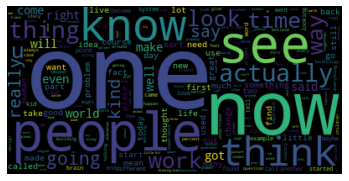

In [17]:
wordcloud = wc.generate(' '.join(all_words))
pl.imshow(wordcloud, interpolation='bilinear')
pl.axis("off")

## Value Ranges

In [18]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
duration,2386.0,8.238785e+02,3.367919e+02,135.0,579.25,856.0,1053.00,3608.0
views,2386.0,1.695917e+06,2.444475e+06,138915.0,756080.50,1125707.0,1702883.25,45622906.0
unique_words,2386.0,5.112154e+02,1.957710e+02,1.0,371.00,526.0,643.00,1280.0
year_published,2386.0,2.011982e+03,2.959630e+00,2006.0,2010.00,2012.0,2014.00,2017.0
month_published,2386.0,6.293797e+00,3.387054e+00,1.0,3.00,6.0,9.00,12.0
num_one,2386.0,7.951383e+00,5.673594e+00,0.0,4.00,7.0,11.00,47.0
num_people,2386.0,7.737636e+00,8.187370e+00,0.0,2.00,5.0,11.00,59.0
num_now,2386.0,6.661358e+00,5.858871e+00,0.0,2.00,5.0,9.00,47.0
num_know,2386.0,5.303856e+00,6.435186e+00,0.0,1.00,3.5,7.00,86.0
num_going,2386.0,5.248952e+00,5.943343e+00,0.0,1.00,3.0,7.00,80.0


## Word length

<AxesSubplot:ylabel='Count'>

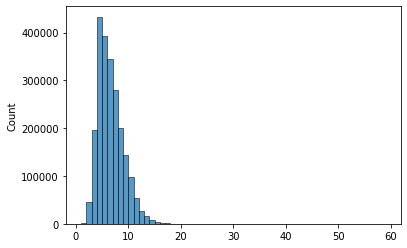

In [19]:
sns.histplot(word_length,binwidth=1)

## Duration

<AxesSubplot:xlabel='duration', ylabel='Count'>

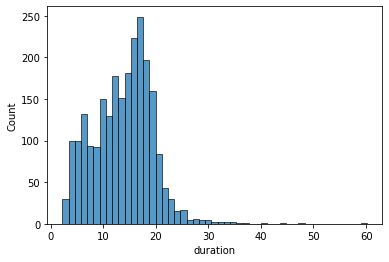

In [20]:
sns.histplot(df['duration']/60)

## Views

<AxesSubplot:xlabel='views', ylabel='Count'>

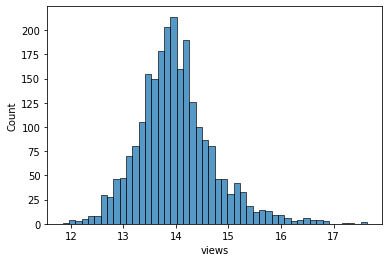

In [21]:
sns.histplot(np.log1p(df['views']))

## Unique words in speech

<AxesSubplot:xlabel='unique_words', ylabel='Count'>

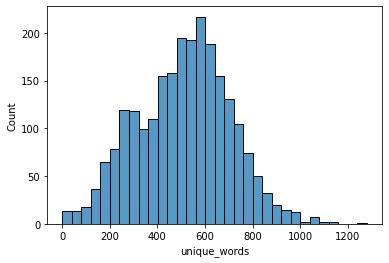

In [22]:
sns.histplot(df['unique_words'])

## Laughter

<AxesSubplot:xlabel='times_laughter', ylabel='Count'>

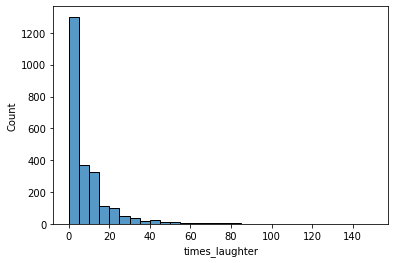

In [23]:
sns.histplot(df['times_laughter'],binwidth=5)

## Applause

<AxesSubplot:xlabel='times_applause', ylabel='Count'>

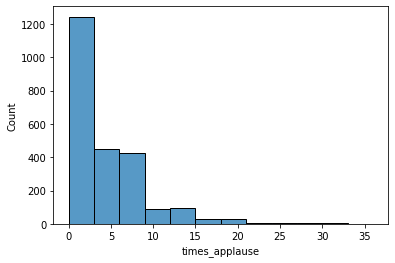

In [24]:
sns.histplot(df['times_applause'],binwidth=3)

## Publish Date

<AxesSubplot:xlabel='date_published', ylabel='Count'>

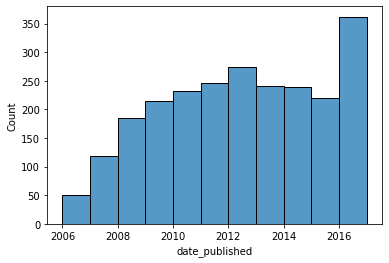

In [25]:
sns.histplot(df['date_published'].dt.year,binwidth=1)

## Correlation

In [26]:
numerical_columns = df.select_dtypes(include='number').columns
corr = df[numerical_columns].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

/var/folders/ks/w_gw7dpd45xfmd1xm4cbg94r0000gn/T/ipykernel_4554/2616795852.py:3: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(2)


,duration,views,unique_words,year_published,month_published,num_one,num_people,num_now,num_know,num_going,num_think,num_see,num_us,num_really,num_time,num_world,num_will,num_actually,num_way,num_years,num_things,num_want,num_go,num_make,num_well,num_right,num_said,num_first,num_something,num_much,num_two,num_look,num_new,num_even,num_thing,num_got,num_little,num_say,num_back,num_work,num_many,num_life,num_need,num_take,num_lot,num_every,num_around,num_good,num_kind,num_different,num_come,num_use,num_day,num_put,num_three,times_laughter,times_applause
duration,1.00,0.06,0.86,-0.17,-0.02,0.59,0.45,0.47,0.44,0.44,0.49,0.36,0.40,0.36,0.43,0.38,0.38,0.28,0.49,0.43,0.40,0.38,0.45,0.35,0.46,0.37,0.34,0.45,0.41,0.45,0.41,0.37,0.26,0.40,0.44,0.37,0.34,0.45,0.42,0.33,0.40,0.26,0.30,0.35,0.39,0.32,0.33,0.35,0.35,0.32,0.41,0.22,0.24,0.38,0.34,0.27,0.23
views,0.06,1.00,0.04,-0.02,-0.01,0.06,0.11,0.03,0.07,0.04,0.08,-0.02,-0.01,0.05,0.05,0.00,0.02,-0.01,0.07,0.00,0.05,0.14,0.06,0.02,-0.01,0.09,0.15,0.02,0.05,0.03,0.09,0.03,-0.03,0.05,0.06,0.05,0.01,0.15,0.04,0.05,-0.01,0.08,0.03,0.02,-0.01,0.02,0.00,0.08,-0.02,0.00,0.05,-0.01,0.04,0.02,0.07,0.28,0.15
unique_words,0.86,0.04,1.00,-0.14,-0.01,0.60,0.45,0.46,0.39,0.38,0.44,0.34,0.44,0.35,0.44,0.40,0.34,0.29,0.47,0.46,0.38,0.33,0.41,0.35,0.43,0.33,0.29,0.47,0.37,0.44,0.41,0.34,0.32,0.43,0.40,0.35,0.32,0.39,0.42,0.34,0.39,0.24,0.31,0.36,0.37,0.34,0.37,0.31,0.33,0.30,0.36,0.23,0.26,0.36,0.34,0.22,0.09
year_published,-0.17,-0.02,-0.14,1.00,-0.12,-0.21,-0.07,-0.14,-0.21,-0.20,-0.15,-0.15,0.04,-0.15,-0.06,-0.11,-0.07,-0.14,-0.15,-0.13,-0.21,-0.15,-0.21,-0.13,-0.15,-0.09,-0.12,-0.08,-0.15,-0.12,-0.11,-0.14,-0.04,0.08,-0.22,-0.19,-0.20,-0.16,-0.13,-0.04,0.02,-0.08,-0.02,-0.07,-0.12,-0.01,-0.10,-0.13,-0.20,-0.08,-0.13,-0.07,0.01,-0.22,-0.12,-0.12,0.03
month_published,-0.02,-0.01,-0.01,-0.12,1.00,0.01,0.03,-0.00,0.02,-0.02,-0.01,0.04,0.03,-0.02,-0.02,0.02,-0.00,0.02,-0.00,-0.02,-0.01,-0.01,-0.00,0.00,0.01,0.00,-0.00,-0.00,0.00,-0.01,0.00,0.04,0.01,0.01,0.00,-0.04,-0.03,0.01,-0.02,-0.03,0.00,0.02,-0.01,0.00,-0.02,0.01,0.02,0.00,-0.00,-0.03,-0.00,-0.03,0.00,-0.00,0.02,-0.01,-0.03
num_one,0.59,0.06,0.60,-0.21,0.01,1.00,0.32,0.37,0.33,0.36,0.38,0.32,0.24,0.32,0.33,0.23,0.28,0.26,0.39,0.27,0.39,0.32,0.39,0.31,0.36,0.33,0.26,0.32,0.36,0.35,0.46,0.31,0.17,0.28,0.42,0.31,0.33,0.34,0.30,0.22,0.27,0.17,0.17,0.27,0.31,0.28,0.28,0.29,0.26,0.31,0.27,0.16,0.21,0.34,0.36,0.24,0.09
num_people,0.45,0.11,0.45,-0.07,0.03,0.32,1.00,0.22,0.28,0.27,0.42,0.13,0.29,0.27,0.24,0.30,0.17,0.16,0.31,0.20,0.35,0.33,0.25,0.25,0.26,0.21,0.24,0.21,0.31,0.31,0.22,0.18,0.13,0.24,0.30,0.22,0.13,0.38,0.16,0.27,0.32,0.11,0.23,0.16,0.35,0.21,0.21,0.28,0.20,0.18,0.24,0.13,0.20,0.19,0.17,0.12,0.05
num_now,0.47,0.03,0.46,-0.14,-0.00,0.37,0.22,1.00,0.23,0.35,0.33,0.31,0.24,0.26,0.26,0.21,0.28,0.27,0.31,0.27,0.25,0.26,0.29,0.23,0.36,0.36,0.08,0.29,0.27,0.33,0.26,0.34,0.19,0.25,0.30,0.22,0.27,0.26,0.24,0.14,0.25,0.06,0.18,0.32,0.24,0.18,0.24,0.24,0.20,0.30,0.19,0.23,0.06,0.32,0.21,0.15,0.08
num_know,0.44,0.07,0.39,-0.21,0.02,0.33,0.28,0.23,1.00,0.41,0.37,0.20,0.18,0.37,0.30,0.14,0.17,0.18,0.31,0.19,0.36,0.34,0.36,0.24,0.33,0.33,0.33,0.22,0.33,0.26,0.20,0.26,0.09,0.16,0.44,0.37,0.32,0.46,0.28,0.19,0.18,0.17,0.18,0.19,0.32,0.18,0.17,0.26,0.33,0.15,0.30,0.10,0.16,0.23,0.17,0.28,0.11
num_going,0.44,0.04,0.38,-0.20,-0.02,0.36,0.27,0.35,0.41,1.00,0.39,0.31,0.22,0.40,0.27,0.13,0.21,0.27,0.34,0.26,0.39,0.37,0.46,0.29,0.32,0.34,0.23,0.25,0.34,0.29,0.26,0.34,0.10,0.14,0.41,0.39,0.35,0.34,0.30,0.20,0.12,0.14,0.24,0.28,0.38,0.18,0.25,0.25,0.26,0.21,0.27,0.22,0.13,0.33,0.20,0.19,0.12


# Model Selection and Tuning

In [27]:
val_frac   = 0.2
test_frac  = 0.2
train_frac = 1.0 - val_frac - test_frac

df_model = df[numerical_columns]

df_full_train = df_model     .sample(frac=train_frac + val_frac         ,random_state=0)
df_train      = df_full_train.sample(frac=val_frac/(train_frac+val_frac),random_state=0)
df_val        = df_full_train.drop(df_train.index     )
df_test       = df_model     .drop(df_full_train.index)

y_full_train = np.log1p(df_full_train.pop('views'))
y_train      = np.log1p(df_train     .pop('views'))
y_val        = np.log1p(df_val       .pop('views'))
y_test       = np.log1p(df_test      .pop('views'))

(df_full_train.shape,df_train.shape,df_val.shape,df_test.shape)

((1909, 56), (477, 56), (1432, 56), (477, 56))

## Simple Linear Regression 'Neural Net'

In [28]:
def train_linear_model(df_train,y_train,df_val,y_val,learning_rate=0.1):
    normalizer = tf.keras.layers.Normalization(axis=-1)
    normalizer.adapt(np.asarray(df_train))
    
    linear_model = tf.keras.Sequential([normalizer,layers.Dense(units=1)])
    linear_model.summary()
    
    linear_model.compile(optimizer=tf.optimizers.Adam(learning_rate=learning_rate)
                    ,loss='mean_squared_error')
    linear_history = linear_model.fit(df_train,y_train,epochs=100,validation_data=(np.asarray(df_val),y_val))
    return linear_history

In [29]:
linear_history = train_linear_model(df_train,y_train,df_val,y_val)

2021-12-13 18:46:24.977369: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 56)               113       
 n)                                                              
                                                                 
 dense (Dense)               (None, 1)                 57        
                                                                 
Total params: 170
Trainable params: 57
Non-trainable params: 113
_________________________________________________________________
Epoch 1/100
15/15 [==============================] - 1s 14ms/step - loss: 191.2464 - val_loss: 161.9771
Epoch 2/100
15/15 [==============================] - 0s 6ms/step - loss: 146.7094 - val_loss: 125.5446
Epoch 3/100
15/15 [==============================] - 0s 5ms/step - loss: 112.4802 - val_loss: 95.8504
Epoch 4/100
15/15 [==============================] - 0s 5ms/step - loss: 85.43

15/15 [==============================] - 0s 5ms/step - loss: 0.4438 - val_loss: 0.6014
Epoch 76/100
15/15 [==============================] - 0s 6ms/step - loss: 0.4439 - val_loss: 0.5677
Epoch 77/100
15/15 [==============================] - 0s 5ms/step - loss: 0.4471 - val_loss: 0.6220
Epoch 78/100
15/15 [==============================] - 0s 5ms/step - loss: 0.4436 - val_loss: 0.5952
Epoch 79/100
15/15 [==============================] - 0s 5ms/step - loss: 0.4519 - val_loss: 0.5986
Epoch 80/100
15/15 [==============================] - 0s 5ms/step - loss: 0.4497 - val_loss: 0.5874
Epoch 81/100
15/15 [==============================] - 0s 5ms/step - loss: 0.4209 - val_loss: 0.5548
Epoch 82/100
15/15 [==============================] - 0s 5ms/step - loss: 0.4174 - val_loss: 0.5771
Epoch 83/100
15/15 [==============================] - 0s 5ms/step - loss: 0.4170 - val_loss: 0.5569
Epoch 84/100
15/15 [==============================] - 0s 6ms/step - loss: 0.4469 - val_loss: 0.5629
Epoch 85/100


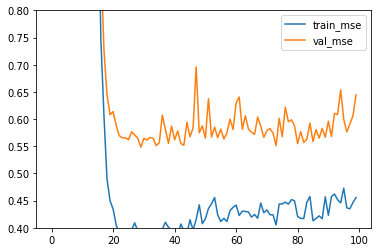

In [30]:
pl.plot(linear_history.history['loss']    ,label='train_mse')
pl.plot(linear_history.history['val_loss'],label='val_mse')
pl.ylim(0.4,0.8)
pl.legend()

### Tuneing of linear model

In [31]:
linear_models = {}
for learning_rate in [0.001,0.01,0.1,0.33,0.66]:
    linear_models[learning_rate] = train_linear_model(df_train,y_train,df_val,y_val,learning_rate=learning_rate)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 56)               113       
 ion)                                                            
                                                                 
 dense_1 (Dense)             (None, 1)                 57        
                                                                 
Total params: 170
Trainable params: 57
Non-trainable params: 113
_________________________________________________________________
Epoch 1/100
15/15 [==============================] - 0s 12ms/step - loss: 197.1654 - val_loss: 196.7473
Epoch 2/100
15/15 [==============================] - 0s 6ms/step - loss: 196.6748 - val_loss: 196.3301
Epoch 3/100
15/15 [==============================] - 0s 6ms/step - loss: 196.2548 - val_loss: 195.8922
Epoch 4/100
15/15 [==============================] - 0s 6ms/step - loss: 19

15/15 [==============================] - 0s 5ms/step - loss: 168.2527 - val_loss: 168.3824
Epoch 73/100
15/15 [==============================] - 0s 5ms/step - loss: 167.8904 - val_loss: 168.0010
Epoch 74/100
15/15 [==============================] - 0s 5ms/step - loss: 167.4955 - val_loss: 167.6312
Epoch 75/100
15/15 [==============================] - 0s 5ms/step - loss: 167.1127 - val_loss: 167.2500
Epoch 76/100
15/15 [==============================] - 0s 5ms/step - loss: 166.7435 - val_loss: 166.8741
Epoch 77/100
15/15 [==============================] - 0s 5ms/step - loss: 166.3708 - val_loss: 166.5009
Epoch 78/100
15/15 [==============================] - 0s 5ms/step - loss: 165.9673 - val_loss: 166.1289
Epoch 79/100
15/15 [==============================] - 0s 5ms/step - loss: 165.6045 - val_loss: 165.7618
Epoch 80/100
15/15 [==============================] - 0s 5ms/step - loss: 165.2263 - val_loss: 165.3931
Epoch 81/100
15/15 [==============================] - 0s 5ms/step - loss: 164

15/15 [==============================] - 0s 5ms/step - loss: 67.9079 - val_loss: 67.4698
Epoch 45/100
15/15 [==============================] - 0s 5ms/step - loss: 65.9858 - val_loss: 65.5418
Epoch 46/100
15/15 [==============================] - 0s 5ms/step - loss: 64.1428 - val_loss: 63.7157
Epoch 47/100
15/15 [==============================] - 0s 5ms/step - loss: 62.4025 - val_loss: 61.9218
Epoch 48/100
15/15 [==============================] - 0s 5ms/step - loss: 60.6226 - val_loss: 60.1872
Epoch 49/100
15/15 [==============================] - 0s 5ms/step - loss: 58.8946 - val_loss: 58.5761
Epoch 50/100
15/15 [==============================] - 0s 5ms/step - loss: 57.2117 - val_loss: 56.9003
Epoch 51/100
15/15 [==============================] - 0s 6ms/step - loss: 55.5797 - val_loss: 55.2702
Epoch 52/100
15/15 [==============================] - 0s 5ms/step - loss: 53.9495 - val_loss: 53.6650
Epoch 53/100
15/15 [==============================] - 0s 5ms/step - loss: 52.5014 - val_loss: 5

15/15 [==============================] - 0s 7ms/step - loss: 0.7503 - val_loss: 0.8501
Epoch 18/100
15/15 [==============================] - 0s 5ms/step - loss: 0.5761 - val_loss: 0.7129
Epoch 19/100
15/15 [==============================] - 0s 5ms/step - loss: 0.4836 - val_loss: 0.6514
Epoch 20/100
15/15 [==============================] - 0s 5ms/step - loss: 0.4314 - val_loss: 0.6069
Epoch 21/100
15/15 [==============================] - 0s 5ms/step - loss: 0.4102 - val_loss: 0.5991
Epoch 22/100
15/15 [==============================] - 0s 5ms/step - loss: 0.3955 - val_loss: 0.5910
Epoch 23/100
15/15 [==============================] - 0s 5ms/step - loss: 0.3967 - val_loss: 0.5857
Epoch 24/100
15/15 [==============================] - 0s 5ms/step - loss: 0.3916 - val_loss: 0.5638
Epoch 25/100
15/15 [==============================] - 0s 5ms/step - loss: 0.4018 - val_loss: 0.5541
Epoch 26/100
15/15 [==============================] - 0s 5ms/step - loss: 0.4121 - val_loss: 0.5480
Epoch 27/100


15/15 [==============================] - 0s 6ms/step - loss: 0.4595 - val_loss: 0.6304
Epoch 100/100
15/15 [==============================] - 0s 6ms/step - loss: 0.4838 - val_loss: 0.6289
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_4 (Normalizat  (None, 56)               113       
 ion)                                                            
                                                                 
 dense_4 (Dense)             (None, 1)                 57        
                                                                 
Total params: 170
Trainable params: 57
Non-trainable params: 113
_________________________________________________________________
Epoch 1/100
15/15 [==============================] - 0s 12ms/step - loss: 178.7476 - val_loss: 91.1344
Epoch 2/100
15/15 [==============================] - 0s 5ms/step - loss: 62.4979 - val_loss: 2

15/15 [==============================] - 0s 12ms/step - loss: 1.1111 - val_loss: 1.1195
Epoch 74/100
15/15 [==============================] - 0s 8ms/step - loss: 1.1783 - val_loss: 1.3974
Epoch 75/100
15/15 [==============================] - 0s 9ms/step - loss: 1.1729 - val_loss: 1.6820
Epoch 76/100
15/15 [==============================] - 0s 7ms/step - loss: 1.1247 - val_loss: 1.0284
Epoch 77/100
15/15 [==============================] - 0s 18ms/step - loss: 1.1474 - val_loss: 1.2234
Epoch 78/100
15/15 [==============================] - 0s 6ms/step - loss: 1.0251 - val_loss: 1.3081
Epoch 79/100
15/15 [==============================] - 0s 6ms/step - loss: 1.0920 - val_loss: 1.3036
Epoch 80/100
15/15 [==============================] - 0s 9ms/step - loss: 1.5797 - val_loss: 2.0220
Epoch 81/100
15/15 [==============================] - 0s 6ms/step - loss: 2.3649 - val_loss: 2.3218
Epoch 82/100
15/15 [==============================] - 0s 9ms/step - loss: 3.1226 - val_loss: 3.7794
Epoch 83/10

15/15 [==============================] - 0s 6ms/step - loss: 2.8854 - val_loss: 2.1756
Epoch 48/100
15/15 [==============================] - 0s 6ms/step - loss: 2.9517 - val_loss: 3.4656
Epoch 49/100
15/15 [==============================] - 0s 6ms/step - loss: 3.4828 - val_loss: 2.2787
Epoch 50/100
15/15 [==============================] - 0s 6ms/step - loss: 1.9384 - val_loss: 1.9307
Epoch 51/100
15/15 [==============================] - 0s 6ms/step - loss: 1.8589 - val_loss: 1.8817
Epoch 52/100
15/15 [==============================] - 0s 6ms/step - loss: 1.7523 - val_loss: 1.6105
Epoch 53/100
15/15 [==============================] - 0s 6ms/step - loss: 1.3109 - val_loss: 1.3738
Epoch 54/100
15/15 [==============================] - 0s 6ms/step - loss: 1.2019 - val_loss: 1.2088
Epoch 55/100
15/15 [==============================] - 0s 6ms/step - loss: 1.3268 - val_loss: 2.2602
Epoch 56/100
15/15 [==============================] - 0s 6ms/step - loss: 2.2402 - val_loss: 2.4727
Epoch 57/100


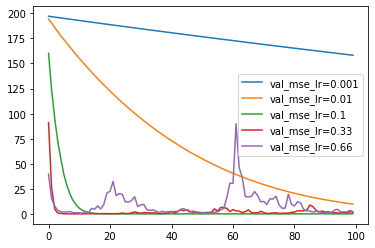

In [32]:
for k,v in linear_models.items():
    pl.plot(v.history['val_loss'],label=f'val_mse_lr={k}')
pl.legend()

## DNN of 1 Inner Layer

In [33]:
def train_NN(df_train,y_train,df_val,y_val,inner_layers=[64],learning_rate=0.1,droprate=None,input_droprate=None):
    normalizer = tf.keras.layers.Normalization(axis=-1)
    normalizer.adapt(np.asarray(df_train))
    
    model = tf.keras.Sequential()
    model.add(normalizer)
    if input_droprate:
        model.add(layers.Dropout(droprate))
    for layer_size in inner_layers:
        model.add(layers.Dense(layer_size, activation='relu'))
        if droprate:
            model.add(layers.Dropout(droprate))
    model.add(layers.Dense(units=1))
    model.summary()
    
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=learning_rate)
                    ,loss='mean_squared_error')
    history = model.fit(df_train,y_train,epochs=200,validation_data=(np.asarray(df_val),y_val))
    return history

In [34]:
NN_history = train_NN(df_train,y_train,df_val,y_val)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_6 (Normalizat  (None, 56)               113       
 ion)                                                            
                                                                 
 dense_6 (Dense)             (None, 64)                3648      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 3,826
Trainable params: 3,713
Non-trainable params: 113
_________________________________________________________________
Epoch 1/200
15/15 [==============================] - 0s 12ms/step - loss: 83.6675 - val_loss: 61.2660
Epoch 2/200
15/15 [==============================] - 0s 6ms/step - loss: 23.9495 - val_loss: 15.5869
Epoch 3/200
15/15 [==========================

15/15 [==============================] - 0s 6ms/step - loss: 0.1927 - val_loss: 2.0708
Epoch 75/200
15/15 [==============================] - 0s 6ms/step - loss: 0.1980 - val_loss: 2.0145
Epoch 76/200
15/15 [==============================] - 0s 6ms/step - loss: 0.2700 - val_loss: 2.3038
Epoch 77/200
15/15 [==============================] - 0s 6ms/step - loss: 0.2414 - val_loss: 2.0842
Epoch 78/200
15/15 [==============================] - 0s 6ms/step - loss: 0.2243 - val_loss: 2.1184
Epoch 79/200
15/15 [==============================] - 0s 6ms/step - loss: 0.2713 - val_loss: 2.3321
Epoch 80/200
15/15 [==============================] - 0s 6ms/step - loss: 0.3756 - val_loss: 2.5065
Epoch 81/200
15/15 [==============================] - 0s 6ms/step - loss: 0.3987 - val_loss: 2.0625
Epoch 82/200
15/15 [==============================] - 0s 6ms/step - loss: 0.3363 - val_loss: 2.0773
Epoch 83/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4600 - val_loss: 2.3114
Epoch 84/200


15/15 [==============================] - 0s 6ms/step - loss: 0.1032 - val_loss: 1.2491
Epoch 156/200
15/15 [==============================] - 0s 6ms/step - loss: 0.1372 - val_loss: 1.2388
Epoch 157/200
15/15 [==============================] - 0s 6ms/step - loss: 0.1673 - val_loss: 1.2001
Epoch 158/200
15/15 [==============================] - 0s 6ms/step - loss: 0.1666 - val_loss: 1.4286
Epoch 159/200
15/15 [==============================] - 0s 6ms/step - loss: 0.2827 - val_loss: 1.3455
Epoch 160/200
15/15 [==============================] - 0s 6ms/step - loss: 0.1867 - val_loss: 1.2612
Epoch 161/200
15/15 [==============================] - 0s 6ms/step - loss: 0.1698 - val_loss: 1.2435
Epoch 162/200
15/15 [==============================] - 0s 6ms/step - loss: 0.1570 - val_loss: 1.1922
Epoch 163/200
15/15 [==============================] - 0s 6ms/step - loss: 0.1251 - val_loss: 1.2495
Epoch 164/200
15/15 [==============================] - 0s 6ms/step - loss: 0.0875 - val_loss: 1.2561
Epoc

(0.0, 4.0)

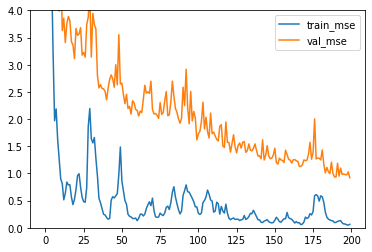

In [35]:
pl.plot(NN_history.history['loss']    ,label='train_mse')
pl.plot(NN_history.history['val_loss'],label='val_mse')
pl.legend()
pl.ylim(0,4)

### DNN of 1 Inner Layer Tuneing

We run each of the tuning sets to pick the best layer size, learning rate and droprate, picking the best in each case and repeating all these steps until the best in each parameter no longer changes. This method is useable because the training for this model is not very computationally intensive.

In [36]:
best_layer_size = [16]
best_learning_rate = 0.1
best_droprate = 0.4
best_input_droprate = 0.4

In [37]:
NN_tuning_layer_size = {}
for layer_size in [4,8,16,32,64]:
    NN_tuning_layer_size[layer_size] = train_NN(df_train,y_train,df_val,y_val
                                               ,inner_layers=[layer_size]
                                               ,droprate=best_droprate
                                               ,learning_rate=best_learning_rate
                                               ,input_droprate=best_input_droprate)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_7 (Normalizat  (None, 56)               113       
 ion)                                                            
                                                                 
 dropout (Dropout)           (None, 56)                0         
                                                                 
 dense_8 (Dense)             (None, 4)                 228       
                                                                 
 dropout_1 (Dropout)         (None, 4)                 0         
                                                                 
 dense_9 (Dense)             (None, 1)                 5         
                                                                 
Total params: 346
Trainable params: 233
Non-trainable params: 113
______________________________________________________

15/15 [==============================] - 0s 6ms/step - loss: 0.5152 - val_loss: 0.5142
Epoch 72/200
15/15 [==============================] - 0s 7ms/step - loss: 0.5193 - val_loss: 0.5076
Epoch 73/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5632 - val_loss: 0.5010
Epoch 74/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4818 - val_loss: 0.5360
Epoch 75/200
15/15 [==============================] - 0s 10ms/step - loss: 0.5243 - val_loss: 0.5219
Epoch 76/200
15/15 [==============================] - 0s 10ms/step - loss: 0.5650 - val_loss: 0.5210
Epoch 77/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5289 - val_loss: 0.5162
Epoch 78/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5948 - val_loss: 0.5392
Epoch 79/200
15/15 [==============================] - 0s 9ms/step - loss: 0.6196 - val_loss: 0.7291
Epoch 80/200
15/15 [==============================] - 0s 7ms/step - loss: 0.6317 - val_loss: 0.5735
Epoch 81/20

15/15 [==============================] - 0s 6ms/step - loss: 0.4734 - val_loss: 0.5508
Epoch 153/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5227 - val_loss: 0.5443
Epoch 154/200
15/15 [==============================] - 0s 5ms/step - loss: 0.4759 - val_loss: 0.4985
Epoch 155/200
15/15 [==============================] - 0s 7ms/step - loss: 0.4855 - val_loss: 0.5253
Epoch 156/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4546 - val_loss: 0.5475
Epoch 157/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5150 - val_loss: 0.4996
Epoch 158/200
15/15 [==============================] - 0s 5ms/step - loss: 0.4695 - val_loss: 0.4946
Epoch 159/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4474 - val_loss: 0.5147
Epoch 160/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5059 - val_loss: 0.4999
Epoch 161/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4730 - val_loss: 0.5171
Epoc

Epoch 22/200
15/15 [==============================] - 0s 6ms/step - loss: 1.0951 - val_loss: 0.5999
Epoch 23/200
15/15 [==============================] - 0s 5ms/step - loss: 0.9269 - val_loss: 0.5690
Epoch 24/200
15/15 [==============================] - 0s 5ms/step - loss: 0.8024 - val_loss: 0.6011
Epoch 25/200
15/15 [==============================] - 0s 5ms/step - loss: 0.7422 - val_loss: 0.5895
Epoch 26/200
15/15 [==============================] - 0s 5ms/step - loss: 0.7141 - val_loss: 0.5358
Epoch 27/200
15/15 [==============================] - 0s 6ms/step - loss: 0.6936 - val_loss: 0.5096
Epoch 28/200
15/15 [==============================] - 0s 6ms/step - loss: 0.7564 - val_loss: 0.6331
Epoch 29/200
15/15 [==============================] - 0s 5ms/step - loss: 0.6396 - val_loss: 0.5306
Epoch 30/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5780 - val_loss: 0.5672
Epoch 31/200
15/15 [==============================] - 0s 5ms/step - loss: 0.6066 - val_loss: 0.5265


Epoch 104/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5463 - val_loss: 0.5107
Epoch 105/200
15/15 [==============================] - 0s 5ms/step - loss: 0.4760 - val_loss: 0.5399
Epoch 106/200
15/15 [==============================] - 0s 5ms/step - loss: 0.5784 - val_loss: 0.5611
Epoch 107/200
15/15 [==============================] - 0s 5ms/step - loss: 0.5548 - val_loss: 0.5024
Epoch 108/200
15/15 [==============================] - 0s 5ms/step - loss: 0.5051 - val_loss: 0.4971
Epoch 109/200
15/15 [==============================] - 0s 5ms/step - loss: 0.4757 - val_loss: 0.5701
Epoch 110/200
15/15 [==============================] - 0s 5ms/step - loss: 0.4950 - val_loss: 0.5006
Epoch 111/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4628 - val_loss: 0.5030
Epoch 112/200
15/15 [==============================] - 0s 5ms/step - loss: 0.4851 - val_loss: 0.4947
Epoch 113/200
15/15 [==============================] - 0s 5ms/step - loss: 0.4771 - val_los

15/15 [==============================] - 0s 7ms/step - loss: 0.4706 - val_loss: 0.5253
Epoch 186/200
15/15 [==============================] - 0s 7ms/step - loss: 0.5423 - val_loss: 0.5240
Epoch 187/200
15/15 [==============================] - 0s 5ms/step - loss: 0.4653 - val_loss: 0.5065
Epoch 188/200
15/15 [==============================] - 0s 5ms/step - loss: 0.4590 - val_loss: 0.5071
Epoch 189/200
15/15 [==============================] - 0s 5ms/step - loss: 0.4937 - val_loss: 0.5092
Epoch 190/200
15/15 [==============================] - 0s 5ms/step - loss: 0.4637 - val_loss: 0.5096
Epoch 191/200
15/15 [==============================] - 0s 5ms/step - loss: 0.4920 - val_loss: 0.5198
Epoch 192/200
15/15 [==============================] - 0s 5ms/step - loss: 0.4687 - val_loss: 0.5172
Epoch 193/200
15/15 [==============================] - 0s 5ms/step - loss: 0.4746 - val_loss: 0.5326
Epoch 194/200
15/15 [==============================] - 0s 7ms/step - loss: 0.4781 - val_loss: 0.5059
Epoc

15/15 [==============================] - 0s 5ms/step - loss: 0.5639 - val_loss: 0.5178
Epoch 56/200
15/15 [==============================] - 0s 5ms/step - loss: 0.5787 - val_loss: 0.5474
Epoch 57/200
15/15 [==============================] - 0s 5ms/step - loss: 0.6741 - val_loss: 0.5452
Epoch 58/200
15/15 [==============================] - 0s 5ms/step - loss: 0.6861 - val_loss: 0.5971
Epoch 59/200
15/15 [==============================] - 0s 7ms/step - loss: 0.7320 - val_loss: 0.5522
Epoch 60/200
15/15 [==============================] - 0s 5ms/step - loss: 0.6149 - val_loss: 0.6428
Epoch 61/200
15/15 [==============================] - 0s 5ms/step - loss: 0.6525 - val_loss: 0.5934
Epoch 62/200
15/15 [==============================] - 0s 5ms/step - loss: 0.6344 - val_loss: 0.5215
Epoch 63/200
15/15 [==============================] - 0s 5ms/step - loss: 0.5322 - val_loss: 0.5063
Epoch 64/200
15/15 [==============================] - 0s 5ms/step - loss: 0.5118 - val_loss: 0.5200
Epoch 65/200


15/15 [==============================] - 0s 5ms/step - loss: 0.5118 - val_loss: 0.5206
Epoch 137/200
15/15 [==============================] - 0s 5ms/step - loss: 0.5254 - val_loss: 0.5395
Epoch 138/200
15/15 [==============================] - 0s 5ms/step - loss: 0.4923 - val_loss: 0.5316
Epoch 139/200
15/15 [==============================] - 0s 5ms/step - loss: 0.4744 - val_loss: 0.5145
Epoch 140/200
15/15 [==============================] - 0s 5ms/step - loss: 0.4764 - val_loss: 0.5312
Epoch 141/200
15/15 [==============================] - 0s 5ms/step - loss: 0.4756 - val_loss: 0.6093
Epoch 142/200
15/15 [==============================] - 0s 5ms/step - loss: 0.4957 - val_loss: 0.5103
Epoch 143/200
15/15 [==============================] - 0s 5ms/step - loss: 0.4719 - val_loss: 0.5327
Epoch 144/200
15/15 [==============================] - 0s 5ms/step - loss: 0.4792 - val_loss: 0.5069
Epoch 145/200
15/15 [==============================] - 0s 5ms/step - loss: 0.5001 - val_loss: 0.5438
Epoc

Epoch 6/200
15/15 [==============================] - 0s 13ms/step - loss: 16.2890 - val_loss: 9.8119
Epoch 7/200
15/15 [==============================] - 0s 11ms/step - loss: 15.5534 - val_loss: 13.9057
Epoch 8/200
15/15 [==============================] - 0s 15ms/step - loss: 11.9353 - val_loss: 7.8668
Epoch 9/200
15/15 [==============================] - 0s 11ms/step - loss: 9.9957 - val_loss: 4.6995
Epoch 10/200
15/15 [==============================] - 0s 8ms/step - loss: 10.2252 - val_loss: 6.8118
Epoch 11/200
15/15 [==============================] - 0s 25ms/step - loss: 7.3668 - val_loss: 9.5379
Epoch 12/200
15/15 [==============================] - 0s 7ms/step - loss: 6.6775 - val_loss: 2.6142
Epoch 13/200
15/15 [==============================] - 0s 6ms/step - loss: 6.3857 - val_loss: 6.0680
Epoch 14/200
15/15 [==============================] - 0s 20ms/step - loss: 6.5388 - val_loss: 4.0197
Epoch 15/200
15/15 [==============================] - 0s 17ms/step - loss: 5.0275 - val_loss:

15/15 [==============================] - 0s 6ms/step - loss: 0.5505 - val_loss: 0.5768
Epoch 88/200
15/15 [==============================] - 0s 5ms/step - loss: 0.5115 - val_loss: 0.5088
Epoch 89/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4818 - val_loss: 0.5224
Epoch 90/200
15/15 [==============================] - 0s 14ms/step - loss: 0.5281 - val_loss: 0.5433
Epoch 91/200
15/15 [==============================] - 0s 9ms/step - loss: 0.5266 - val_loss: 0.5218
Epoch 92/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5070 - val_loss: 0.5517
Epoch 93/200
15/15 [==============================] - 0s 9ms/step - loss: 0.5101 - val_loss: 0.5089
Epoch 94/200
15/15 [==============================] - 0s 7ms/step - loss: 0.4741 - val_loss: 0.5519
Epoch 95/200
15/15 [==============================] - 0s 7ms/step - loss: 0.5071 - val_loss: 0.4971
Epoch 96/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4439 - val_loss: 0.5088
Epoch 97/200

15/15 [==============================] - 0s 6ms/step - loss: 0.4800 - val_loss: 0.5316
Epoch 169/200
15/15 [==============================] - 0s 5ms/step - loss: 0.4935 - val_loss: 0.5788
Epoch 170/200
15/15 [==============================] - 0s 5ms/step - loss: 0.5680 - val_loss: 0.5696
Epoch 171/200
15/15 [==============================] - 0s 5ms/step - loss: 0.5160 - val_loss: 0.5076
Epoch 172/200
15/15 [==============================] - 0s 5ms/step - loss: 0.4890 - val_loss: 0.5306
Epoch 173/200
15/15 [==============================] - 0s 5ms/step - loss: 0.4425 - val_loss: 0.5247
Epoch 174/200
15/15 [==============================] - 0s 5ms/step - loss: 0.4856 - val_loss: 0.5287
Epoch 175/200
15/15 [==============================] - 0s 5ms/step - loss: 0.4323 - val_loss: 0.5291
Epoch 176/200
15/15 [==============================] - 0s 5ms/step - loss: 0.4756 - val_loss: 0.5143
Epoch 177/200
15/15 [==============================] - 0s 5ms/step - loss: 0.5298 - val_loss: 0.5161
Epoc

15/15 [==============================] - 0s 12ms/step - loss: 1.1394 - val_loss: 0.7320
Epoch 39/200
15/15 [==============================] - 0s 11ms/step - loss: 0.9626 - val_loss: 0.6779
Epoch 40/200
15/15 [==============================] - 0s 10ms/step - loss: 0.8933 - val_loss: 0.9675
Epoch 41/200
15/15 [==============================] - 0s 11ms/step - loss: 0.7635 - val_loss: 0.6533
Epoch 42/200
15/15 [==============================] - 0s 6ms/step - loss: 0.7302 - val_loss: 0.5961
Epoch 43/200
15/15 [==============================] - 0s 6ms/step - loss: 0.7300 - val_loss: 0.7580
Epoch 44/200
15/15 [==============================] - 0s 5ms/step - loss: 0.7695 - val_loss: 0.9144
Epoch 45/200
15/15 [==============================] - 0s 7ms/step - loss: 0.7923 - val_loss: 0.5992
Epoch 46/200
15/15 [==============================] - 0s 6ms/step - loss: 0.7179 - val_loss: 0.6382
Epoch 47/200
15/15 [==============================] - 0s 6ms/step - loss: 0.8131 - val_loss: 0.8499
Epoch 48/

Epoch 120/200
15/15 [==============================] - 0s 12ms/step - loss: 0.4405 - val_loss: 0.5270
Epoch 121/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4021 - val_loss: 0.5285
Epoch 122/200
15/15 [==============================] - 0s 5ms/step - loss: 0.4436 - val_loss: 0.5263
Epoch 123/200
15/15 [==============================] - 0s 8ms/step - loss: 0.4211 - val_loss: 0.5234
Epoch 124/200
15/15 [==============================] - 0s 7ms/step - loss: 0.4505 - val_loss: 0.5503
Epoch 125/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4512 - val_loss: 0.5589
Epoch 126/200
15/15 [==============================] - 0s 5ms/step - loss: 0.4355 - val_loss: 0.5121
Epoch 127/200
15/15 [==============================] - 0s 5ms/step - loss: 0.4144 - val_loss: 0.5196
Epoch 128/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4088 - val_loss: 0.5219
Epoch 129/200
15/15 [==============================] - 0s 5ms/step - loss: 0.4340 - val_lo

(0.4, 0.6)

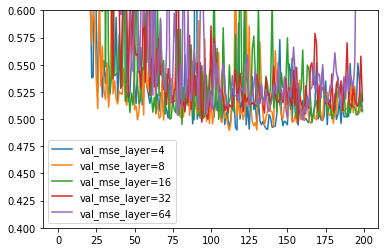

In [38]:
for k,v in NN_tuning_layer_size.items():
    pl.plot(v.history['val_loss'],label=f'val_mse_layer={k}')
pl.legend()
pl.ylim(0.4,0.6)

In [39]:
NN_tuning_learning_rate = {}
for learning_rate in [0.01,0.1,0.33,0.66]:
    NN_tuning_learning_rate[learning_rate] = train_NN(df_train,y_train,df_val,y_val
                                                     ,inner_layers=best_layer_size
                                                     ,droprate=best_droprate
                                                     ,learning_rate=learning_rate
                                                     ,input_droprate=best_input_droprate)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_12 (Normaliza  (None, 56)               113       
 tion)                                                           
                                                                 
 dropout_10 (Dropout)        (None, 56)                0         
                                                                 
 dense_18 (Dense)            (None, 16)                912       
                                                                 
 dropout_11 (Dropout)        (None, 16)                0         
                                                                 
 dense_19 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,042
Trainable params: 929
Non-trainable params: 113
___________________________________________________

Epoch 71/200
15/15 [==============================] - 0s 5ms/step - loss: 6.4433 - val_loss: 1.3106
Epoch 72/200
15/15 [==============================] - 0s 5ms/step - loss: 5.4334 - val_loss: 0.7192
Epoch 73/200
15/15 [==============================] - 0s 5ms/step - loss: 6.6086 - val_loss: 1.3631
Epoch 74/200
15/15 [==============================] - 0s 5ms/step - loss: 6.6191 - val_loss: 0.9009
Epoch 75/200
15/15 [==============================] - 0s 5ms/step - loss: 6.3310 - val_loss: 1.1148
Epoch 76/200
15/15 [==============================] - 0s 8ms/step - loss: 6.1524 - val_loss: 0.8478
Epoch 77/200
15/15 [==============================] - 0s 6ms/step - loss: 6.0947 - val_loss: 1.5828
Epoch 78/200
15/15 [==============================] - 0s 5ms/step - loss: 5.6503 - val_loss: 1.0438
Epoch 79/200
15/15 [==============================] - 0s 5ms/step - loss: 6.0415 - val_loss: 0.9801
Epoch 80/200
15/15 [==============================] - 0s 5ms/step - loss: 5.6102 - val_loss: 1.3204


15/15 [==============================] - 0s 6ms/step - loss: 2.4580 - val_loss: 0.8913
Epoch 153/200
15/15 [==============================] - 0s 6ms/step - loss: 2.8240 - val_loss: 0.6308
Epoch 154/200
15/15 [==============================] - 0s 5ms/step - loss: 2.3146 - val_loss: 0.8003
Epoch 155/200
15/15 [==============================] - 0s 6ms/step - loss: 2.5906 - val_loss: 0.6422
Epoch 156/200
15/15 [==============================] - 0s 6ms/step - loss: 2.5482 - val_loss: 0.7290
Epoch 157/200
15/15 [==============================] - 0s 6ms/step - loss: 2.5122 - val_loss: 0.6182
Epoch 158/200
15/15 [==============================] - 0s 6ms/step - loss: 2.3915 - val_loss: 0.6214
Epoch 159/200
15/15 [==============================] - 0s 5ms/step - loss: 2.3278 - val_loss: 0.5605
Epoch 160/200
15/15 [==============================] - 0s 6ms/step - loss: 2.5393 - val_loss: 0.6859
Epoch 161/200
15/15 [==============================] - 0s 6ms/step - loss: 2.2406 - val_loss: 0.5306
Epoc

Epoch 22/200
15/15 [==============================] - 0s 9ms/step - loss: 1.7499 - val_loss: 0.6976
Epoch 23/200
15/15 [==============================] - 0s 9ms/step - loss: 1.3430 - val_loss: 0.8690
Epoch 24/200
15/15 [==============================] - 0s 6ms/step - loss: 1.2337 - val_loss: 0.7231
Epoch 25/200
15/15 [==============================] - 0s 7ms/step - loss: 1.0404 - val_loss: 0.7091
Epoch 26/200
15/15 [==============================] - 0s 6ms/step - loss: 1.0622 - val_loss: 0.8186
Epoch 27/200
15/15 [==============================] - 0s 6ms/step - loss: 0.8063 - val_loss: 0.5951
Epoch 28/200
15/15 [==============================] - 0s 6ms/step - loss: 0.9269 - val_loss: 0.8557
Epoch 29/200
15/15 [==============================] - 0s 6ms/step - loss: 0.8971 - val_loss: 0.5482
Epoch 30/200
15/15 [==============================] - 0s 6ms/step - loss: 0.8092 - val_loss: 1.1226
Epoch 31/200
15/15 [==============================] - 0s 6ms/step - loss: 0.8023 - val_loss: 0.5775


Epoch 104/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5696 - val_loss: 0.5042
Epoch 105/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5527 - val_loss: 0.5612
Epoch 106/200
15/15 [==============================] - 0s 8ms/step - loss: 0.5184 - val_loss: 0.5596
Epoch 107/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4871 - val_loss: 0.4988
Epoch 108/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5005 - val_loss: 0.5264
Epoch 109/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5133 - val_loss: 0.5385
Epoch 110/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4870 - val_loss: 0.5041
Epoch 111/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4805 - val_loss: 0.5030
Epoch 112/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4456 - val_loss: 0.5343
Epoch 113/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5008 - val_los

Epoch 185/200
15/15 [==============================] - 0s 14ms/step - loss: 0.4410 - val_loss: 0.5270
Epoch 186/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4457 - val_loss: 0.5105
Epoch 187/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4984 - val_loss: 0.5104
Epoch 188/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5057 - val_loss: 0.5713
Epoch 189/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5087 - val_loss: 0.5211
Epoch 190/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4594 - val_loss: 0.5138
Epoch 191/200
15/15 [==============================] - 0s 8ms/step - loss: 0.4587 - val_loss: 0.5221
Epoch 192/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4969 - val_loss: 0.5204
Epoch 193/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4939 - val_loss: 0.5177
Epoch 194/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5011 - val_lo

15/15 [==============================] - 0s 6ms/step - loss: 0.8583 - val_loss: 0.6648
Epoch 56/200
15/15 [==============================] - 0s 8ms/step - loss: 0.8293 - val_loss: 0.5762
Epoch 57/200
15/15 [==============================] - 0s 7ms/step - loss: 0.6415 - val_loss: 0.5620
Epoch 58/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5983 - val_loss: 0.5326
Epoch 59/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5439 - val_loss: 0.5419
Epoch 60/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5384 - val_loss: 0.5354
Epoch 61/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5513 - val_loss: 0.5378
Epoch 62/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5817 - val_loss: 0.5396
Epoch 63/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5193 - val_loss: 0.5606
Epoch 64/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5909 - val_loss: 0.5343
Epoch 65/200


15/15 [==============================] - 0s 7ms/step - loss: 0.5122 - val_loss: 0.5345
Epoch 137/200
15/15 [==============================] - 0s 7ms/step - loss: 0.4754 - val_loss: 0.5346
Epoch 138/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4690 - val_loss: 0.5295
Epoch 139/200
15/15 [==============================] - 0s 13ms/step - loss: 0.4595 - val_loss: 0.5276
Epoch 140/200
15/15 [==============================] - 0s 9ms/step - loss: 0.4330 - val_loss: 0.5177
Epoch 141/200
15/15 [==============================] - 0s 7ms/step - loss: 0.4777 - val_loss: 0.5331
Epoch 142/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5081 - val_loss: 0.5364
Epoch 143/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4708 - val_loss: 0.5229
Epoch 144/200
15/15 [==============================] - 0s 10ms/step - loss: 0.4980 - val_loss: 0.5284
Epoch 145/200
15/15 [==============================] - 0s 7ms/step - loss: 0.4843 - val_loss: 0.5447
Ep

15/15 [==============================] - 0s 10ms/step - loss: 423.8537 - val_loss: 29.0979
Epoch 6/200
15/15 [==============================] - 0s 11ms/step - loss: 65.0095 - val_loss: 10.6602
Epoch 7/200
15/15 [==============================] - 0s 9ms/step - loss: 30.2460 - val_loss: 4.9213
Epoch 8/200
15/15 [==============================] - 0s 13ms/step - loss: 9.1206 - val_loss: 1.0405
Epoch 9/200
15/15 [==============================] - 0s 10ms/step - loss: 2.8634 - val_loss: 0.7468
Epoch 10/200
15/15 [==============================] - 0s 7ms/step - loss: 1.4408 - val_loss: 0.7422
Epoch 11/200
15/15 [==============================] - 0s 8ms/step - loss: 1.0721 - val_loss: 0.5769
Epoch 12/200
15/15 [==============================] - 0s 7ms/step - loss: 0.7413 - val_loss: 0.5623
Epoch 13/200
15/15 [==============================] - 0s 6ms/step - loss: 0.6064 - val_loss: 0.5241
Epoch 14/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5624 - val_loss: 0.5665
Epoch 1

Epoch 87/200
15/15 [==============================] - 0s 6ms/step - loss: 224.7700 - val_loss: 116.8658
Epoch 88/200
15/15 [==============================] - 0s 6ms/step - loss: 2660.5371 - val_loss: 1347.1332
Epoch 89/200
15/15 [==============================] - 0s 8ms/step - loss: 38227.1641 - val_loss: 48391.7188
Epoch 90/200
15/15 [==============================] - 0s 6ms/step - loss: 227743.9375 - val_loss: 56957.4648
Epoch 91/200
15/15 [==============================] - 0s 6ms/step - loss: 162589.6875 - val_loss: 88431.1641
Epoch 92/200
15/15 [==============================] - 0s 6ms/step - loss: 248590.3594 - val_loss: 13162.7832
Epoch 93/200
15/15 [==============================] - 0s 6ms/step - loss: 132483.3125 - val_loss: 22007.9375
Epoch 94/200
15/15 [==============================] - 0s 6ms/step - loss: 119865.5156 - val_loss: 6215.0386
Epoch 95/200
15/15 [==============================] - 0s 6ms/step - loss: 30140.2402 - val_loss: 2290.6355
Epoch 96/200
15/15 [===========

Epoch 167/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5342 - val_loss: 0.5471
Epoch 168/200
15/15 [==============================] - 0s 8ms/step - loss: 0.5800 - val_loss: 0.5419
Epoch 169/200
15/15 [==============================] - 0s 7ms/step - loss: 0.5837 - val_loss: 0.5421
Epoch 170/200
15/15 [==============================] - 0s 23ms/step - loss: 0.5921 - val_loss: 0.5459
Epoch 171/200
15/15 [==============================] - 0s 18ms/step - loss: 0.5742 - val_loss: 0.5540
Epoch 172/200
15/15 [==============================] - 0s 6ms/step - loss: 0.8035 - val_loss: 0.5653
Epoch 173/200
15/15 [==============================] - 0s 6ms/step - loss: 0.6688 - val_loss: 0.5424
Epoch 174/200
15/15 [==============================] - 0s 5ms/step - loss: 0.5629 - val_loss: 0.5405
Epoch 175/200
15/15 [==============================] - 0s 11ms/step - loss: 0.5580 - val_loss: 0.5403
Epoch 176/200
15/15 [==============================] - 0s 11ms/step - loss: 0.5742 - val

(0.4, 0.6)

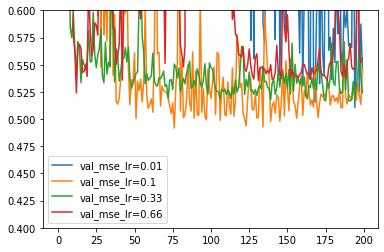

In [40]:
for k,v in NN_tuning_learning_rate.items():
    pl.plot(v.history['val_loss'],label=f'val_mse_lr={k}')
pl.legend()
pl.ylim(0.4,0.6)

In [41]:
NN_tuneing_dropout = {}
for droprate in [0.0,0.2,0.4,0.6,0.8]:
    NN_tuneing_dropout[droprate] = train_NN(df_train,y_train,df_val,y_val
                                           ,inner_layers=best_layer_size
                                           ,droprate=droprate
                                           ,learning_rate=best_learning_rate
                                           ,input_droprate=best_input_droprate)

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_16 (Normaliza  (None, 56)               113       
 tion)                                                           
                                                                 
 dropout_18 (Dropout)        (None, 56)                0         
                                                                 
 dense_26 (Dense)            (None, 16)                912       
                                                                 
 dense_27 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,042
Trainable params: 929
Non-trainable params: 113
_________________________________________________________________
Epoch 1/200
15/15 [==============================] - 1s 13ms/step - loss: 59.7121 - val_loss: 24.3679
Epoch 2/200
15/

Epoch 73/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4154 - val_loss: 2.6042
Epoch 74/200
15/15 [==============================] - 0s 6ms/step - loss: 0.7753 - val_loss: 2.8012
Epoch 75/200
15/15 [==============================] - 0s 7ms/step - loss: 0.6926 - val_loss: 2.5550
Epoch 76/200
15/15 [==============================] - 0s 7ms/step - loss: 0.6125 - val_loss: 2.2420
Epoch 77/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5219 - val_loss: 1.9272
Epoch 78/200
15/15 [==============================] - 0s 6ms/step - loss: 0.6174 - val_loss: 2.3599
Epoch 79/200
15/15 [==============================] - 0s 6ms/step - loss: 0.7894 - val_loss: 2.2511
Epoch 80/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5763 - val_loss: 2.2009
Epoch 81/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5403 - val_loss: 1.9710
Epoch 82/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4681 - val_loss: 1.9150


15/15 [==============================] - 0s 5ms/step - loss: 0.1234 - val_loss: 1.4671
Epoch 155/200
15/15 [==============================] - 0s 5ms/step - loss: 0.1081 - val_loss: 1.4493
Epoch 156/200
15/15 [==============================] - 0s 5ms/step - loss: 0.1384 - val_loss: 1.4678
Epoch 157/200
15/15 [==============================] - 0s 5ms/step - loss: 0.1177 - val_loss: 1.4147
Epoch 158/200
15/15 [==============================] - 0s 5ms/step - loss: 0.1435 - val_loss: 1.3652
Epoch 159/200
15/15 [==============================] - 0s 5ms/step - loss: 0.1535 - val_loss: 1.4515
Epoch 160/200
15/15 [==============================] - 0s 6ms/step - loss: 0.2858 - val_loss: 1.3853
Epoch 161/200
15/15 [==============================] - 0s 5ms/step - loss: 0.3031 - val_loss: 1.4268
Epoch 162/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4015 - val_loss: 1.4228
Epoch 163/200
15/15 [==============================] - 0s 6ms/step - loss: 0.2725 - val_loss: 1.4942
Epoc

15/15 [==============================] - 0s 5ms/step - loss: 2.0244 - val_loss: 1.1481
Epoch 25/200
15/15 [==============================] - 0s 5ms/step - loss: 2.2334 - val_loss: 1.2815
Epoch 26/200
15/15 [==============================] - 0s 5ms/step - loss: 1.5409 - val_loss: 1.5459
Epoch 27/200
15/15 [==============================] - 0s 7ms/step - loss: 1.7658 - val_loss: 0.9586
Epoch 28/200
15/15 [==============================] - 0s 6ms/step - loss: 1.4470 - val_loss: 0.8835
Epoch 29/200
15/15 [==============================] - 0s 6ms/step - loss: 1.4001 - val_loss: 1.0486
Epoch 30/200
15/15 [==============================] - 0s 5ms/step - loss: 1.2786 - val_loss: 0.7638
Epoch 31/200
15/15 [==============================] - 0s 5ms/step - loss: 1.3744 - val_loss: 0.7798
Epoch 32/200
15/15 [==============================] - 0s 5ms/step - loss: 1.3490 - val_loss: 1.6910
Epoch 33/200
15/15 [==============================] - 0s 5ms/step - loss: 1.2078 - val_loss: 0.9654
Epoch 34/200


Epoch 106/200
15/15 [==============================] - 0s 6ms/step - loss: 0.3907 - val_loss: 0.5311
Epoch 107/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4077 - val_loss: 0.6121
Epoch 108/200
15/15 [==============================] - 0s 6ms/step - loss: 0.6260 - val_loss: 0.5173
Epoch 109/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4651 - val_loss: 0.5521
Epoch 110/200
15/15 [==============================] - 0s 5ms/step - loss: 0.4058 - val_loss: 0.5513
Epoch 111/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4005 - val_loss: 0.5863
Epoch 112/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4303 - val_loss: 0.5298
Epoch 113/200
15/15 [==============================] - 0s 6ms/step - loss: 0.3926 - val_loss: 0.6199
Epoch 114/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4110 - val_loss: 0.5239
Epoch 115/200
15/15 [==============================] - 0s 5ms/step - loss: 0.4121 - val_los

15/15 [==============================] - 0s 6ms/step - loss: 0.3716 - val_loss: 0.6072
Epoch 188/200
15/15 [==============================] - 0s 5ms/step - loss: 0.3724 - val_loss: 0.5805
Epoch 189/200
15/15 [==============================] - 0s 5ms/step - loss: 0.3840 - val_loss: 0.5597
Epoch 190/200
15/15 [==============================] - 0s 5ms/step - loss: 0.3484 - val_loss: 0.5550
Epoch 191/200
15/15 [==============================] - 0s 5ms/step - loss: 0.3649 - val_loss: 0.5429
Epoch 192/200
15/15 [==============================] - 0s 5ms/step - loss: 0.3277 - val_loss: 0.5641
Epoch 193/200
15/15 [==============================] - 0s 5ms/step - loss: 0.3797 - val_loss: 0.5706
Epoch 194/200
15/15 [==============================] - 0s 5ms/step - loss: 0.3399 - val_loss: 0.5564
Epoch 195/200
15/15 [==============================] - 0s 5ms/step - loss: 0.3570 - val_loss: 0.5734
Epoch 196/200
15/15 [==============================] - 0s 5ms/step - loss: 0.3418 - val_loss: 0.5873
Epoc

15/15 [==============================] - 0s 7ms/step - loss: 0.6010 - val_loss: 0.5837
Epoch 58/200
15/15 [==============================] - 0s 7ms/step - loss: 0.7102 - val_loss: 0.7816
Epoch 59/200
15/15 [==============================] - 0s 7ms/step - loss: 0.7560 - val_loss: 0.5962
Epoch 60/200
15/15 [==============================] - 0s 6ms/step - loss: 0.8218 - val_loss: 0.6970
Epoch 61/200
15/15 [==============================] - 0s 6ms/step - loss: 0.7436 - val_loss: 0.5449
Epoch 62/200
15/15 [==============================] - 0s 6ms/step - loss: 0.7741 - val_loss: 0.7571
Epoch 63/200
15/15 [==============================] - 0s 6ms/step - loss: 0.6904 - val_loss: 0.5407
Epoch 64/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5480 - val_loss: 0.5145
Epoch 65/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5102 - val_loss: 0.5035
Epoch 66/200
15/15 [==============================] - 0s 6ms/step - loss: 0.6147 - val_loss: 0.5018
Epoch 67/200


15/15 [==============================] - 0s 15ms/step - loss: 0.4654 - val_loss: 0.5120
Epoch 139/200
15/15 [==============================] - 0s 10ms/step - loss: 0.4623 - val_loss: 0.5194
Epoch 140/200
15/15 [==============================] - 0s 8ms/step - loss: 0.5088 - val_loss: 0.5160
Epoch 141/200
15/15 [==============================] - 0s 14ms/step - loss: 0.4427 - val_loss: 0.5453
Epoch 142/200
15/15 [==============================] - 0s 11ms/step - loss: 0.4636 - val_loss: 0.5103
Epoch 143/200
15/15 [==============================] - 0s 8ms/step - loss: 0.4604 - val_loss: 0.5400
Epoch 144/200
15/15 [==============================] - 0s 9ms/step - loss: 0.4523 - val_loss: 0.5356
Epoch 145/200
15/15 [==============================] - 0s 7ms/step - loss: 0.4458 - val_loss: 0.5235
Epoch 146/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5090 - val_loss: 0.5107
Epoch 147/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4751 - val_loss: 0.5023


15/15 [==============================] - 0s 6ms/step - loss: 19.1201 - val_loss: 11.0835
Epoch 8/200
15/15 [==============================] - 0s 8ms/step - loss: 16.5339 - val_loss: 9.9165
Epoch 9/200
15/15 [==============================] - 0s 6ms/step - loss: 13.5554 - val_loss: 9.5075
Epoch 10/200
15/15 [==============================] - 0s 6ms/step - loss: 10.2694 - val_loss: 5.8486
Epoch 11/200
15/15 [==============================] - 0s 6ms/step - loss: 8.3744 - val_loss: 4.6878
Epoch 12/200
15/15 [==============================] - 0s 6ms/step - loss: 5.8148 - val_loss: 4.7748
Epoch 13/200
15/15 [==============================] - 0s 6ms/step - loss: 4.5213 - val_loss: 3.5499
Epoch 14/200
15/15 [==============================] - 0s 6ms/step - loss: 3.7286 - val_loss: 3.6361
Epoch 15/200
15/15 [==============================] - 0s 6ms/step - loss: 2.8981 - val_loss: 1.5583
Epoch 16/200
15/15 [==============================] - 0s 6ms/step - loss: 2.6071 - val_loss: 1.0422
Epoch 17/2

Epoch 89/200
15/15 [==============================] - 0s 8ms/step - loss: 0.5918 - val_loss: 0.5411
Epoch 90/200
15/15 [==============================] - 0s 8ms/step - loss: 0.5677 - val_loss: 0.5294
Epoch 91/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5755 - val_loss: 0.5791
Epoch 92/200
15/15 [==============================] - 0s 6ms/step - loss: 0.6574 - val_loss: 0.5206
Epoch 93/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5646 - val_loss: 0.5186
Epoch 94/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5746 - val_loss: 0.5349
Epoch 95/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5920 - val_loss: 0.5582
Epoch 96/200
15/15 [==============================] - 0s 15ms/step - loss: 0.5436 - val_loss: 0.5168
Epoch 97/200
15/15 [==============================] - 0s 9ms/step - loss: 0.5594 - val_loss: 0.5204
Epoch 98/200
15/15 [==============================] - 0s 7ms/step - loss: 0.5489 - val_loss: 0.5795

15/15 [==============================] - 0s 8ms/step - loss: 0.5094 - val_loss: 0.5234
Epoch 171/200
15/15 [==============================] - 0s 13ms/step - loss: 0.4991 - val_loss: 0.5175
Epoch 172/200
15/15 [==============================] - 0s 8ms/step - loss: 0.5152 - val_loss: 0.5233
Epoch 173/200
15/15 [==============================] - 0s 7ms/step - loss: 0.4976 - val_loss: 0.5179
Epoch 174/200
15/15 [==============================] - 0s 7ms/step - loss: 0.5200 - val_loss: 0.5269
Epoch 175/200
15/15 [==============================] - 0s 7ms/step - loss: 0.5253 - val_loss: 0.5232
Epoch 176/200
15/15 [==============================] - 0s 13ms/step - loss: 0.5207 - val_loss: 0.5236
Epoch 177/200
15/15 [==============================] - 0s 9ms/step - loss: 0.5052 - val_loss: 0.5267
Epoch 178/200
15/15 [==============================] - 0s 7ms/step - loss: 0.5056 - val_loss: 0.5205
Epoch 179/200
15/15 [==============================] - 0s 14ms/step - loss: 0.4970 - val_loss: 0.5264
E

15/15 [==============================] - 0s 10ms/step - loss: 0.6135 - val_loss: 0.5393
Epoch 40/200
15/15 [==============================] - 0s 11ms/step - loss: 0.5650 - val_loss: 0.5335
Epoch 41/200
15/15 [==============================] - 0s 9ms/step - loss: 0.5919 - val_loss: 0.5345
Epoch 42/200
15/15 [==============================] - 0s 10ms/step - loss: 0.6055 - val_loss: 0.5397
Epoch 43/200
15/15 [==============================] - 0s 14ms/step - loss: 0.6939 - val_loss: 0.5376
Epoch 44/200
15/15 [==============================] - 0s 9ms/step - loss: 0.7196 - val_loss: 0.5666
Epoch 45/200
15/15 [==============================] - 0s 11ms/step - loss: 0.6832 - val_loss: 0.5269
Epoch 46/200
15/15 [==============================] - 0s 12ms/step - loss: 0.5868 - val_loss: 0.5368
Epoch 47/200
15/15 [==============================] - 0s 10ms/step - loss: 0.5890 - val_loss: 0.5386
Epoch 48/200
15/15 [==============================] - 0s 8ms/step - loss: 0.6586 - val_loss: 0.5434
Epoch 

15/15 [==============================] - 0s 12ms/step - loss: 0.6457 - val_loss: 0.5435
Epoch 121/200
15/15 [==============================] - 0s 8ms/step - loss: 0.5774 - val_loss: 0.5376
Epoch 122/200
15/15 [==============================] - 0s 7ms/step - loss: 0.5735 - val_loss: 0.5385
Epoch 123/200
15/15 [==============================] - 0s 7ms/step - loss: 0.5449 - val_loss: 0.5405
Epoch 124/200
15/15 [==============================] - 0s 7ms/step - loss: 0.5890 - val_loss: 0.5426
Epoch 125/200
15/15 [==============================] - 0s 7ms/step - loss: 0.5467 - val_loss: 0.5392
Epoch 126/200
15/15 [==============================] - 0s 8ms/step - loss: 0.6115 - val_loss: 0.5395
Epoch 127/200
15/15 [==============================] - 0s 7ms/step - loss: 0.5651 - val_loss: 0.5374
Epoch 128/200
15/15 [==============================] - 0s 10ms/step - loss: 0.5573 - val_loss: 0.5345
Epoch 129/200
15/15 [==============================] - 0s 8ms/step - loss: 0.5470 - val_loss: 0.5386
Ep

(0.4, 0.6)

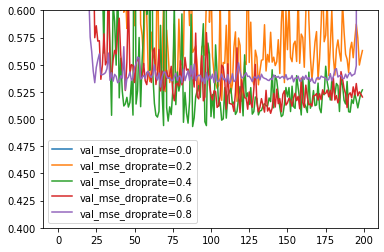

In [42]:
for k,v in NN_tuneing_dropout.items():
    pl.plot(v.history['val_loss'],label=f'val_mse_droprate={k}')
pl.legend()
pl.ylim(0.4,0.6)

In [43]:
NN_tuneing_input_dropout = {}
for droprate in [0.0,0.2,0.4,0.6,0.8]:
    NN_tuneing_input_dropout[droprate] = train_NN(df_train,y_train,df_val,y_val
                                           ,inner_layers=best_layer_size
                                           ,droprate=best_droprate
                                           ,learning_rate=best_learning_rate
                                           ,input_droprate=droprate)

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_21 (Normaliza  (None, 56)               113       
 tion)                                                           
                                                                 
 dense_36 (Dense)            (None, 16)                912       
                                                                 
 dropout_27 (Dropout)        (None, 16)                0         
                                                                 
 dense_37 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,042
Trainable params: 929
Non-trainable params: 113
_________________________________________________________________
Epoch 1/200
15/15 [==============================] - 0s 11ms/step - loss: 98.0093 - val_loss: 43.9180
Epoch 2/200
15/

15/15 [==============================] - 0s 6ms/step - loss: 0.3736 - val_loss: 0.5722
Epoch 73/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4138 - val_loss: 0.5798
Epoch 74/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4087 - val_loss: 0.5582
Epoch 75/200
15/15 [==============================] - 0s 6ms/step - loss: 0.3863 - val_loss: 0.5533
Epoch 76/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4599 - val_loss: 0.5613
Epoch 77/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4159 - val_loss: 0.5881
Epoch 78/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4535 - val_loss: 0.5919
Epoch 79/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4295 - val_loss: 0.5647
Epoch 80/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4183 - val_loss: 0.5406
Epoch 81/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4162 - val_loss: 0.5749
Epoch 82/200


15/15 [==============================] - 0s 6ms/step - loss: 0.3026 - val_loss: 0.6404
Epoch 154/200
15/15 [==============================] - 0s 6ms/step - loss: 0.2888 - val_loss: 0.6409
Epoch 155/200
15/15 [==============================] - 0s 6ms/step - loss: 0.2878 - val_loss: 0.6251
Epoch 156/200
15/15 [==============================] - 0s 6ms/step - loss: 0.2990 - val_loss: 0.6011
Epoch 157/200
15/15 [==============================] - 0s 6ms/step - loss: 0.2977 - val_loss: 0.6353
Epoch 158/200
15/15 [==============================] - 0s 6ms/step - loss: 0.2782 - val_loss: 0.7145
Epoch 159/200
15/15 [==============================] - 0s 6ms/step - loss: 0.2696 - val_loss: 0.7672
Epoch 160/200
15/15 [==============================] - 0s 6ms/step - loss: 0.3219 - val_loss: 0.7463
Epoch 161/200
15/15 [==============================] - 0s 6ms/step - loss: 0.2931 - val_loss: 0.6233
Epoch 162/200
15/15 [==============================] - 0s 6ms/step - loss: 0.2739 - val_loss: 0.6100
Epoc

15/15 [==============================] - 0s 6ms/step - loss: 1.5178 - val_loss: 1.0953
Epoch 24/200
15/15 [==============================] - 0s 6ms/step - loss: 1.1165 - val_loss: 0.9564
Epoch 25/200
15/15 [==============================] - 0s 6ms/step - loss: 1.0345 - val_loss: 0.9256
Epoch 26/200
15/15 [==============================] - 0s 6ms/step - loss: 1.3008 - val_loss: 0.6344
Epoch 27/200
15/15 [==============================] - 0s 6ms/step - loss: 1.1781 - val_loss: 0.5921
Epoch 28/200
15/15 [==============================] - 0s 6ms/step - loss: 0.8766 - val_loss: 0.7165
Epoch 29/200
15/15 [==============================] - 0s 6ms/step - loss: 0.8048 - val_loss: 0.6270
Epoch 30/200
15/15 [==============================] - 0s 6ms/step - loss: 0.7547 - val_loss: 0.7956
Epoch 31/200
15/15 [==============================] - 0s 6ms/step - loss: 0.8035 - val_loss: 0.6181
Epoch 32/200
15/15 [==============================] - 0s 6ms/step - loss: 0.7596 - val_loss: 0.6743
Epoch 33/200


15/15 [==============================] - 0s 6ms/step - loss: 0.4616 - val_loss: 0.5040
Epoch 106/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5114 - val_loss: 0.5504
Epoch 107/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4993 - val_loss: 0.5845
Epoch 108/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5491 - val_loss: 0.4988
Epoch 109/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4689 - val_loss: 0.5296
Epoch 110/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4797 - val_loss: 0.5122
Epoch 111/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4772 - val_loss: 0.5055
Epoch 112/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4672 - val_loss: 0.5296
Epoch 113/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4880 - val_loss: 0.5422
Epoch 114/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4680 - val_loss: 0.5150
Epoc

15/15 [==============================] - 0s 6ms/step - loss: 0.4742 - val_loss: 0.5080
Epoch 187/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4509 - val_loss: 0.5124
Epoch 188/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4667 - val_loss: 0.5114
Epoch 189/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4455 - val_loss: 0.4979
Epoch 190/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4716 - val_loss: 0.5132
Epoch 191/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4664 - val_loss: 0.5217
Epoch 192/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4626 - val_loss: 0.5268
Epoch 193/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4992 - val_loss: 0.4986
Epoch 194/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4501 - val_loss: 0.5163
Epoch 195/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5062 - val_loss: 0.5250
Epoc

15/15 [==============================] - 0s 6ms/step - loss: 0.7281 - val_loss: 0.5233
Epoch 57/200
15/15 [==============================] - 0s 6ms/step - loss: 0.6062 - val_loss: 0.5979
Epoch 58/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5507 - val_loss: 0.5852
Epoch 59/200
15/15 [==============================] - 0s 7ms/step - loss: 0.5831 - val_loss: 0.5487
Epoch 60/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5516 - val_loss: 0.5163
Epoch 61/200
15/15 [==============================] - 0s 6ms/step - loss: 0.6269 - val_loss: 0.5409
Epoch 62/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5996 - val_loss: 0.4988
Epoch 63/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5755 - val_loss: 0.5280
Epoch 64/200
15/15 [==============================] - 0s 6ms/step - loss: 0.6203 - val_loss: 0.5119
Epoch 65/200
15/15 [==============================] - 0s 6ms/step - loss: 0.6322 - val_loss: 0.4993
Epoch 66/200


15/15 [==============================] - 0s 6ms/step - loss: 0.4426 - val_loss: 0.5413
Epoch 138/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4425 - val_loss: 0.5150
Epoch 139/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4984 - val_loss: 0.4997
Epoch 140/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4961 - val_loss: 0.5102
Epoch 141/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4740 - val_loss: 0.5188
Epoch 142/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5005 - val_loss: 0.5065
Epoch 143/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4613 - val_loss: 0.5163
Epoch 144/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4685 - val_loss: 0.5209
Epoch 145/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5014 - val_loss: 0.5196
Epoch 146/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4479 - val_loss: 0.5336
Epoc

Epoch 7/200
15/15 [==============================] - 0s 6ms/step - loss: 15.1443 - val_loss: 8.8953
Epoch 8/200
15/15 [==============================] - 0s 6ms/step - loss: 11.9753 - val_loss: 3.1659
Epoch 9/200
15/15 [==============================] - 0s 6ms/step - loss: 10.2230 - val_loss: 2.8530
Epoch 10/200
15/15 [==============================] - 0s 6ms/step - loss: 8.1580 - val_loss: 5.5822
Epoch 11/200
15/15 [==============================] - 0s 6ms/step - loss: 6.4551 - val_loss: 5.1668
Epoch 12/200
15/15 [==============================] - 0s 6ms/step - loss: 5.8004 - val_loss: 1.7754
Epoch 13/200
15/15 [==============================] - 0s 6ms/step - loss: 4.8633 - val_loss: 3.9600
Epoch 14/200
15/15 [==============================] - 0s 6ms/step - loss: 4.0698 - val_loss: 1.9115
Epoch 15/200
15/15 [==============================] - 0s 6ms/step - loss: 3.6372 - val_loss: 1.4588
Epoch 16/200
15/15 [==============================] - 0s 6ms/step - loss: 2.7981 - val_loss: 1.4987


Epoch 89/200
15/15 [==============================] - 0s 7ms/step - loss: 0.4887 - val_loss: 0.5065
Epoch 90/200
15/15 [==============================] - 0s 7ms/step - loss: 0.4882 - val_loss: 0.5117
Epoch 91/200
15/15 [==============================] - 0s 7ms/step - loss: 0.5461 - val_loss: 0.5016
Epoch 92/200
15/15 [==============================] - 0s 7ms/step - loss: 0.5487 - val_loss: 0.5506
Epoch 93/200
15/15 [==============================] - 0s 7ms/step - loss: 0.5162 - val_loss: 0.5179
Epoch 94/200
15/15 [==============================] - 0s 7ms/step - loss: 0.4943 - val_loss: 0.5131
Epoch 95/200
15/15 [==============================] - 0s 7ms/step - loss: 0.5023 - val_loss: 0.5553
Epoch 96/200
15/15 [==============================] - 0s 7ms/step - loss: 0.5373 - val_loss: 0.5325
Epoch 97/200
15/15 [==============================] - 0s 9ms/step - loss: 0.5679 - val_loss: 0.4991
Epoch 98/200
15/15 [==============================] - 0s 7ms/step - loss: 0.4894 - val_loss: 0.4942


15/15 [==============================] - 0s 6ms/step - loss: 0.4658 - val_loss: 0.5080
Epoch 171/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4665 - val_loss: 0.5295
Epoch 172/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4481 - val_loss: 0.5168
Epoch 173/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4814 - val_loss: 0.5332
Epoch 174/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4873 - val_loss: 0.5018
Epoch 175/200
15/15 [==============================] - 0s 7ms/step - loss: 0.4702 - val_loss: 0.5258
Epoch 176/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4531 - val_loss: 0.5248
Epoch 177/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4829 - val_loss: 0.4961
Epoch 178/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4629 - val_loss: 0.5133
Epoch 179/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4842 - val_loss: 0.5673
Epoc

15/15 [==============================] - 0s 7ms/step - loss: 0.6994 - val_loss: 0.5094
Epoch 41/200
15/15 [==============================] - 0s 7ms/step - loss: 0.6621 - val_loss: 0.6021
Epoch 42/200
15/15 [==============================] - 0s 6ms/step - loss: 0.7108 - val_loss: 0.5735
Epoch 43/200
15/15 [==============================] - 0s 6ms/step - loss: 0.6744 - val_loss: 0.6728
Epoch 44/200
15/15 [==============================] - 0s 6ms/step - loss: 0.7007 - val_loss: 0.6673
Epoch 45/200
15/15 [==============================] - 0s 6ms/step - loss: 0.6715 - val_loss: 0.5813
Epoch 46/200
15/15 [==============================] - 0s 6ms/step - loss: 0.7527 - val_loss: 0.5119
Epoch 47/200
15/15 [==============================] - 0s 6ms/step - loss: 0.6104 - val_loss: 0.5355
Epoch 48/200
15/15 [==============================] - 0s 6ms/step - loss: 0.6454 - val_loss: 0.5566
Epoch 49/200
15/15 [==============================] - 0s 6ms/step - loss: 0.6110 - val_loss: 0.5433
Epoch 50/200


Epoch 122/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4584 - val_loss: 0.4951
Epoch 123/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4596 - val_loss: 0.5132
Epoch 124/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4747 - val_loss: 0.5146
Epoch 125/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4472 - val_loss: 0.5065
Epoch 126/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4541 - val_loss: 0.5032
Epoch 127/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4806 - val_loss: 0.5341
Epoch 128/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4702 - val_loss: 0.5008
Epoch 129/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4724 - val_loss: 0.5134
Epoch 130/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5014 - val_loss: 0.5415
Epoch 131/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4834 - val_los

(0.4, 0.6)

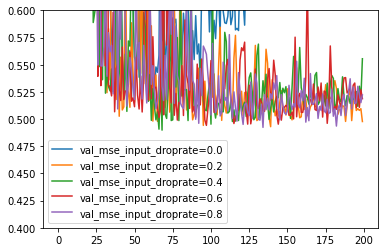

In [44]:
for k,v in NN_tuneing_input_dropout.items():
    pl.plot(v.history['val_loss'],label=f'val_mse_input_droprate={k}')
pl.legend()
pl.ylim(0.4,0.6)

### DNN of 2 Inner Layers Tuneing

Same method as before, keeping both inner layers the same size

In [45]:
best_ddn2_layer_size = [16,16]
best_ddn2_learning_rate = 0.33
best_ddn2_droprate = 0.4
best_ddn2_input_droprate = 0.0

In [46]:
NN2_tuning_layer_size = {}
for layer_size in [2,4,8,16,32,64]:
    NN2_tuning_layer_size[layer_size] = train_NN(df_train,y_train,df_val,y_val
                                                ,inner_layers=[layer_size,layer_size]
                                                ,droprate=best_ddn2_droprate
                                                ,learning_rate=best_ddn2_learning_rate
                                                ,input_droprate=best_ddn2_input_droprate)

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_26 (Normaliza  (None, 56)               113       
 tion)                                                           
                                                                 
 dense_46 (Dense)            (None, 2)                 114       
                                                                 
 dropout_36 (Dropout)        (None, 2)                 0         
                                                                 
 dense_47 (Dense)            (None, 2)                 6         
                                                                 
 dropout_37 (Dropout)        (None, 2)                 0         
                                                                 
 dense_48 (Dense)            (None, 1)                 3         
                                                     

15/15 [==============================] - 0s 6ms/step - loss: 0.5370 - val_loss: 0.5418
Epoch 71/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5260 - val_loss: 0.5387
Epoch 72/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5274 - val_loss: 0.5418
Epoch 73/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5391 - val_loss: 0.5497
Epoch 74/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5297 - val_loss: 0.5398
Epoch 75/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5247 - val_loss: 0.5385
Epoch 76/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5227 - val_loss: 0.5478
Epoch 77/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5375 - val_loss: 0.5458
Epoch 78/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5283 - val_loss: 0.5383
Epoch 79/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5298 - val_loss: 0.5517
Epoch 80/200


15/15 [==============================] - 0s 5ms/step - loss: 0.5252 - val_loss: 0.5384
Epoch 152/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5255 - val_loss: 0.5421
Epoch 153/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5366 - val_loss: 0.5531
Epoch 154/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5285 - val_loss: 0.5434
Epoch 155/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5234 - val_loss: 0.5386
Epoch 156/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5175 - val_loss: 0.5408
Epoch 157/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5294 - val_loss: 0.5391
Epoch 158/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5248 - val_loss: 0.5439
Epoch 159/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5283 - val_loss: 0.5525
Epoch 160/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5289 - val_loss: 0.5383
Epoc

15/15 [==============================] - 0s 19ms/step - loss: 0.5329 - val_loss: 0.5435
Epoch 20/200
15/15 [==============================] - 0s 25ms/step - loss: 0.5435 - val_loss: 0.5524
Epoch 21/200
15/15 [==============================] - 0s 9ms/step - loss: 0.5373 - val_loss: 0.5431
Epoch 22/200
15/15 [==============================] - 0s 8ms/step - loss: 0.5251 - val_loss: 0.5374
Epoch 23/200
15/15 [==============================] - 0s 10ms/step - loss: 0.5464 - val_loss: 0.5368
Epoch 24/200
15/15 [==============================] - 0s 7ms/step - loss: 0.5260 - val_loss: 0.5621
Epoch 25/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5516 - val_loss: 0.5527
Epoch 26/200
15/15 [==============================] - 0s 20ms/step - loss: 0.5305 - val_loss: 0.5388
Epoch 27/200
15/15 [==============================] - 0s 13ms/step - loss: 0.5261 - val_loss: 0.5374
Epoch 28/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5215 - val_loss: 0.5399
Epoch 29

15/15 [==============================] - 0s 10ms/step - loss: 0.5324 - val_loss: 0.5390
Epoch 101/200
15/15 [==============================] - 0s 10ms/step - loss: 0.5264 - val_loss: 0.5386
Epoch 102/200
15/15 [==============================] - 0s 9ms/step - loss: 0.5263 - val_loss: 0.5387
Epoch 103/200
15/15 [==============================] - 0s 10ms/step - loss: 0.5273 - val_loss: 0.5392
Epoch 104/200
15/15 [==============================] - 0s 10ms/step - loss: 0.5269 - val_loss: 0.5380
Epoch 105/200
15/15 [==============================] - 0s 10ms/step - loss: 0.5272 - val_loss: 0.5372
Epoch 106/200
15/15 [==============================] - 0s 9ms/step - loss: 0.5203 - val_loss: 0.5369
Epoch 107/200
15/15 [==============================] - 0s 10ms/step - loss: 0.5318 - val_loss: 0.5396
Epoch 108/200
15/15 [==============================] - 0s 8ms/step - loss: 0.5254 - val_loss: 0.5452
Epoch 109/200
15/15 [==============================] - 0s 8ms/step - loss: 0.5193 - val_loss: 0.540

15/15 [==============================] - 0s 9ms/step - loss: 0.5396 - val_loss: 0.5440
Epoch 182/200
15/15 [==============================] - 0s 9ms/step - loss: 0.5246 - val_loss: 0.5419
Epoch 183/200
15/15 [==============================] - 0s 14ms/step - loss: 0.5263 - val_loss: 0.5372
Epoch 184/200
15/15 [==============================] - 0s 10ms/step - loss: 0.5208 - val_loss: 0.5369
Epoch 185/200
15/15 [==============================] - 0s 9ms/step - loss: 0.5207 - val_loss: 0.5372
Epoch 186/200
15/15 [==============================] - 0s 10ms/step - loss: 0.5188 - val_loss: 0.5371
Epoch 187/200
15/15 [==============================] - 0s 9ms/step - loss: 0.5152 - val_loss: 0.5446
Epoch 188/200
15/15 [==============================] - 0s 9ms/step - loss: 0.5198 - val_loss: 0.5538
Epoch 189/200
15/15 [==============================] - 0s 10ms/step - loss: 0.5231 - val_loss: 0.5438
Epoch 190/200
15/15 [==============================] - 0s 9ms/step - loss: 0.5276 - val_loss: 0.5676


Epoch 50/200
15/15 [==============================] - 0s 7ms/step - loss: 0.5219 - val_loss: 0.5384
Epoch 51/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5226 - val_loss: 0.5386
Epoch 52/200
15/15 [==============================] - 0s 7ms/step - loss: 0.5226 - val_loss: 0.5385
Epoch 53/200
15/15 [==============================] - 0s 9ms/step - loss: 0.5254 - val_loss: 0.5383
Epoch 54/200
15/15 [==============================] - 0s 8ms/step - loss: 0.5217 - val_loss: 0.5393
Epoch 55/200
15/15 [==============================] - 0s 10ms/step - loss: 0.5225 - val_loss: 0.5384
Epoch 56/200
15/15 [==============================] - 0s 7ms/step - loss: 0.5226 - val_loss: 0.5385
Epoch 57/200
15/15 [==============================] - 0s 11ms/step - loss: 0.5232 - val_loss: 0.5386
Epoch 58/200
15/15 [==============================] - 0s 8ms/step - loss: 0.5225 - val_loss: 0.5386
Epoch 59/200
15/15 [==============================] - 0s 7ms/step - loss: 0.5237 - val_loss: 0.539

15/15 [==============================] - 0s 6ms/step - loss: 0.5222 - val_loss: 0.5383
Epoch 132/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5246 - val_loss: 0.5385
Epoch 133/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5332 - val_loss: 0.5421
Epoch 134/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5202 - val_loss: 0.5403
Epoch 135/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5287 - val_loss: 0.5432
Epoch 136/200
15/15 [==============================] - 0s 7ms/step - loss: 0.5268 - val_loss: 0.5387
Epoch 137/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5228 - val_loss: 0.5384
Epoch 138/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5232 - val_loss: 0.5385
Epoch 139/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5229 - val_loss: 0.5389
Epoch 140/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5308 - val_loss: 0.5435
Epoc

15/15 [==============================] - 1s 17ms/step - loss: 207.3519 - val_loss: 126.5557
Epoch 2/200
15/15 [==============================] - 0s 6ms/step - loss: 86.6700 - val_loss: 46.3093
Epoch 3/200
15/15 [==============================] - 0s 6ms/step - loss: 27.6634 - val_loss: 10.9271
Epoch 4/200
15/15 [==============================] - 0s 6ms/step - loss: 5.2553 - val_loss: 1.5764
Epoch 5/200
15/15 [==============================] - 0s 6ms/step - loss: 0.8239 - val_loss: 0.5386
Epoch 6/200
15/15 [==============================] - 0s 5ms/step - loss: 0.5508 - val_loss: 0.5888
Epoch 7/200
15/15 [==============================] - 0s 7ms/step - loss: 0.5601 - val_loss: 0.5604
Epoch 8/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5301 - val_loss: 0.5404
Epoch 9/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5242 - val_loss: 0.5384
Epoch 10/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5221 - val_loss: 0.5383
Epoch 11/200

15/15 [==============================] - 0s 6ms/step - loss: 0.5241 - val_loss: 0.5391
Epoch 84/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5211 - val_loss: 0.5385
Epoch 85/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5234 - val_loss: 0.5389
Epoch 86/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5237 - val_loss: 0.5385
Epoch 87/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5267 - val_loss: 0.5387
Epoch 88/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5237 - val_loss: 0.5383
Epoch 89/200
15/15 [==============================] - 0s 5ms/step - loss: 0.5233 - val_loss: 0.5388
Epoch 90/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5234 - val_loss: 0.5384
Epoch 91/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5243 - val_loss: 0.5414
Epoch 92/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5226 - val_loss: 0.5387
Epoch 93/200


15/15 [==============================] - 0s 6ms/step - loss: 0.5204 - val_loss: 0.5404
Epoch 165/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5232 - val_loss: 0.5391
Epoch 166/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5241 - val_loss: 0.5383
Epoch 167/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5261 - val_loss: 0.5395
Epoch 168/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5304 - val_loss: 0.5421
Epoch 169/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5268 - val_loss: 0.5471
Epoch 170/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5307 - val_loss: 0.5488
Epoch 171/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5261 - val_loss: 0.5388
Epoch 172/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5248 - val_loss: 0.5410
Epoch 173/200
15/15 [==============================] - 0s 8ms/step - loss: 0.5272 - val_loss: 0.5391
Epoc

Epoch 33/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5214 - val_loss: 0.5383
Epoch 34/200
15/15 [==============================] - 0s 5ms/step - loss: 0.5213 - val_loss: 0.5383
Epoch 35/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5218 - val_loss: 0.5383
Epoch 36/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5218 - val_loss: 0.5384
Epoch 37/200
15/15 [==============================] - 0s 5ms/step - loss: 0.5214 - val_loss: 0.5383
Epoch 38/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5217 - val_loss: 0.5383
Epoch 39/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5222 - val_loss: 0.5384
Epoch 40/200
15/15 [==============================] - 0s 5ms/step - loss: 0.5220 - val_loss: 0.5383
Epoch 41/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5214 - val_loss: 0.5384
Epoch 42/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5218 - val_loss: 0.5383


Epoch 115/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5222 - val_loss: 0.5391
Epoch 116/200
15/15 [==============================] - 0s 5ms/step - loss: 0.5222 - val_loss: 0.5385
Epoch 117/200
15/15 [==============================] - 0s 5ms/step - loss: 0.5216 - val_loss: 0.5384
Epoch 118/200
15/15 [==============================] - 0s 5ms/step - loss: 0.5224 - val_loss: 0.5384
Epoch 119/200
15/15 [==============================] - 0s 5ms/step - loss: 0.5219 - val_loss: 0.5383
Epoch 120/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5220 - val_loss: 0.5383
Epoch 121/200
15/15 [==============================] - 0s 5ms/step - loss: 0.5217 - val_loss: 0.5386
Epoch 122/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5232 - val_loss: 0.5384
Epoch 123/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5226 - val_loss: 0.5385
Epoch 124/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5239 - val_los

15/15 [==============================] - 0s 6ms/step - loss: 0.5225 - val_loss: 0.5385
Epoch 197/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5227 - val_loss: 0.5387
Epoch 198/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5219 - val_loss: 0.5388
Epoch 199/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5268 - val_loss: 0.5387
Epoch 200/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5262 - val_loss: 0.5384
Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_31 (Normaliza  (None, 56)               113       
 tion)                                                           
                                                                 
 dense_61 (Dense)            (None, 64)                3648      
                                                                 
 dropout_46 (Dropout)   

15/15 [==============================] - 0s 6ms/step - loss: 0.5214 - val_loss: 0.5383
Epoch 65/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5213 - val_loss: 0.5383
Epoch 66/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5214 - val_loss: 0.5383
Epoch 67/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5214 - val_loss: 0.5383
Epoch 68/200
15/15 [==============================] - 0s 8ms/step - loss: 0.5214 - val_loss: 0.5383
Epoch 69/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5214 - val_loss: 0.5383
Epoch 70/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5215 - val_loss: 0.5384
Epoch 71/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5214 - val_loss: 0.5383
Epoch 72/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5214 - val_loss: 0.5383
Epoch 73/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5214 - val_loss: 0.5383
Epoch 74/200


15/15 [==============================] - 0s 6ms/step - loss: 0.5215 - val_loss: 0.5383
Epoch 146/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5214 - val_loss: 0.5383
Epoch 147/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5214 - val_loss: 0.5383
Epoch 148/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5218 - val_loss: 0.5384
Epoch 149/200
15/15 [==============================] - 0s 7ms/step - loss: 0.5214 - val_loss: 0.5383
Epoch 150/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5215 - val_loss: 0.5384
Epoch 151/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5218 - val_loss: 0.5383
Epoch 152/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5215 - val_loss: 0.5383
Epoch 153/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5214 - val_loss: 0.5383
Epoch 154/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5216 - val_loss: 0.5384
Epoc

(0.52, 0.56)

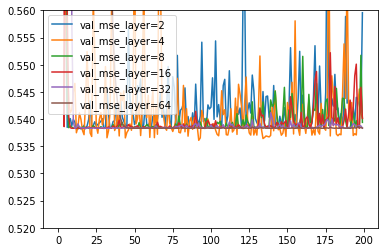

In [47]:
for k,v in NN2_tuning_layer_size.items():
    pl.plot(v.history['val_loss'],label=f'val_mse_layer={k}')
pl.legend()
pl.ylim(0.52,0.56)

In [48]:
NN2_tuning_learning_rate = {}
for learning_rate in [0.01,0.1,0.33,0.66]:
    NN2_tuning_learning_rate[learning_rate] = train_NN(df_train,y_train,df_val,y_val
                                                     ,inner_layers=best_ddn2_layer_size
                                                     ,droprate=best_ddn2_droprate
                                                     ,learning_rate=learning_rate
                                                     ,input_droprate=best_ddn2_input_droprate)

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_32 (Normaliza  (None, 56)               113       
 tion)                                                           
                                                                 
 dense_64 (Dense)            (None, 16)                912       
                                                                 
 dropout_48 (Dropout)        (None, 16)                0         
                                                                 
 dense_65 (Dense)            (None, 16)                272       
                                                                 
 dropout_49 (Dropout)        (None, 16)                0         
                                                                 
 dense_66 (Dense)            (None, 1)                 17        
                                                     

15/15 [==============================] - 0s 6ms/step - loss: 8.1427 - val_loss: 1.2398
Epoch 70/200
15/15 [==============================] - 0s 6ms/step - loss: 7.3534 - val_loss: 0.9399
Epoch 71/200
15/15 [==============================] - 0s 6ms/step - loss: 7.9945 - val_loss: 0.8441
Epoch 72/200
15/15 [==============================] - 0s 5ms/step - loss: 8.4259 - val_loss: 1.1746
Epoch 73/200
15/15 [==============================] - 0s 5ms/step - loss: 7.9458 - val_loss: 1.3412
Epoch 74/200
15/15 [==============================] - 0s 6ms/step - loss: 6.9859 - val_loss: 0.8693
Epoch 75/200
15/15 [==============================] - 0s 5ms/step - loss: 7.7793 - val_loss: 1.0439
Epoch 76/200
15/15 [==============================] - 0s 6ms/step - loss: 6.7021 - val_loss: 1.1476
Epoch 77/200
15/15 [==============================] - 0s 6ms/step - loss: 7.3370 - val_loss: 1.0086
Epoch 78/200
15/15 [==============================] - 0s 6ms/step - loss: 7.5444 - val_loss: 1.3086
Epoch 79/200


15/15 [==============================] - 0s 6ms/step - loss: 2.0934 - val_loss: 0.5668
Epoch 151/200
15/15 [==============================] - 0s 6ms/step - loss: 1.9163 - val_loss: 0.6802
Epoch 152/200
15/15 [==============================] - 0s 6ms/step - loss: 2.1540 - val_loss: 0.6788
Epoch 153/200
15/15 [==============================] - 0s 6ms/step - loss: 1.9402 - val_loss: 0.6072
Epoch 154/200
15/15 [==============================] - 0s 6ms/step - loss: 1.9948 - val_loss: 0.7073
Epoch 155/200
15/15 [==============================] - 0s 6ms/step - loss: 2.0601 - val_loss: 0.5662
Epoch 156/200
15/15 [==============================] - 0s 6ms/step - loss: 2.2413 - val_loss: 0.8092
Epoch 157/200
15/15 [==============================] - 0s 6ms/step - loss: 1.8396 - val_loss: 0.5834
Epoch 158/200
15/15 [==============================] - 0s 6ms/step - loss: 1.8560 - val_loss: 0.6755
Epoch 159/200
15/15 [==============================] - 0s 6ms/step - loss: 1.9132 - val_loss: 0.5408
Epoc

15/15 [==============================] - 0s 6ms/step - loss: 2.2752 - val_loss: 1.4274
Epoch 19/200
15/15 [==============================] - 0s 6ms/step - loss: 1.8210 - val_loss: 1.0076
Epoch 20/200
15/15 [==============================] - 0s 5ms/step - loss: 1.5925 - val_loss: 0.6969
Epoch 21/200
15/15 [==============================] - 0s 5ms/step - loss: 1.5755 - val_loss: 0.6307
Epoch 22/200
15/15 [==============================] - 0s 5ms/step - loss: 1.6426 - val_loss: 0.7353
Epoch 23/200
15/15 [==============================] - 0s 5ms/step - loss: 1.4558 - val_loss: 0.6848
Epoch 24/200
15/15 [==============================] - 0s 5ms/step - loss: 1.3282 - val_loss: 0.7273
Epoch 25/200
15/15 [==============================] - 0s 6ms/step - loss: 1.1090 - val_loss: 0.5330
Epoch 26/200
15/15 [==============================] - 0s 5ms/step - loss: 1.1101 - val_loss: 0.8733
Epoch 27/200
15/15 [==============================] - 0s 5ms/step - loss: 1.0967 - val_loss: 0.6202
Epoch 28/200


15/15 [==============================] - 0s 6ms/step - loss: 0.4189 - val_loss: 0.5210
Epoch 101/200
15/15 [==============================] - 0s 8ms/step - loss: 0.4238 - val_loss: 0.5082
Epoch 102/200
15/15 [==============================] - 0s 7ms/step - loss: 0.4088 - val_loss: 0.5124
Epoch 103/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4200 - val_loss: 0.5227
Epoch 104/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4276 - val_loss: 0.5222
Epoch 105/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4155 - val_loss: 0.5089
Epoch 106/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4188 - val_loss: 0.5106
Epoch 107/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4133 - val_loss: 0.5171
Epoch 108/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4410 - val_loss: 0.5172
Epoch 109/200
15/15 [==============================] - 0s 6ms/step - loss: 0.3939 - val_loss: 0.5236
Epoc

15/15 [==============================] - 0s 6ms/step - loss: 0.3603 - val_loss: 0.5443
Epoch 182/200
15/15 [==============================] - 0s 6ms/step - loss: 0.3154 - val_loss: 0.5549
Epoch 183/200
15/15 [==============================] - 0s 6ms/step - loss: 0.3391 - val_loss: 0.5463
Epoch 184/200
15/15 [==============================] - 0s 7ms/step - loss: 0.2992 - val_loss: 0.5506
Epoch 185/200
15/15 [==============================] - 0s 7ms/step - loss: 0.3609 - val_loss: 0.5311
Epoch 186/200
15/15 [==============================] - 0s 6ms/step - loss: 0.3380 - val_loss: 0.5405
Epoch 187/200
15/15 [==============================] - 0s 6ms/step - loss: 0.3625 - val_loss: 0.5489
Epoch 188/200
15/15 [==============================] - 0s 6ms/step - loss: 0.3608 - val_loss: 0.5351
Epoch 189/200
15/15 [==============================] - 0s 6ms/step - loss: 0.3725 - val_loss: 0.5230
Epoch 190/200
15/15 [==============================] - 0s 6ms/step - loss: 0.3545 - val_loss: 0.5815
Epoc

15/15 [==============================] - 0s 7ms/step - loss: 0.5244 - val_loss: 0.5388
Epoch 51/200
15/15 [==============================] - 0s 7ms/step - loss: 0.5224 - val_loss: 0.5398
Epoch 52/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5214 - val_loss: 0.5386
Epoch 53/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5220 - val_loss: 0.5385
Epoch 54/200
15/15 [==============================] - 0s 15ms/step - loss: 0.5224 - val_loss: 0.5387
Epoch 55/200
15/15 [==============================] - 0s 24ms/step - loss: 0.5244 - val_loss: 0.5384
Epoch 56/200
15/15 [==============================] - 0s 21ms/step - loss: 0.5214 - val_loss: 0.5389
Epoch 57/200
15/15 [==============================] - 0s 11ms/step - loss: 0.5241 - val_loss: 0.5386
Epoch 58/200
15/15 [==============================] - 0s 9ms/step - loss: 0.5254 - val_loss: 0.5386
Epoch 59/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5219 - val_loss: 0.5384
Epoch 60/

15/15 [==============================] - 0s 6ms/step - loss: 0.5234 - val_loss: 0.5435
Epoch 132/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5268 - val_loss: 0.5388
Epoch 133/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5223 - val_loss: 0.5384
Epoch 134/200
15/15 [==============================] - 0s 7ms/step - loss: 0.5228 - val_loss: 0.5387
Epoch 135/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5223 - val_loss: 0.5392
Epoch 136/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5189 - val_loss: 0.5383
Epoch 137/200
15/15 [==============================] - 0s 9ms/step - loss: 0.5172 - val_loss: 0.5381
Epoch 138/200
15/15 [==============================] - 0s 9ms/step - loss: 0.5266 - val_loss: 0.5410
Epoch 139/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5222 - val_loss: 0.5400
Epoch 140/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5275 - val_loss: 0.5424
Epoc

15/15 [==============================] - 1s 19ms/step - loss: 6060.1831 - val_loss: 225.3009
Epoch 2/200
15/15 [==============================] - 0s 8ms/step - loss: 2491.6064 - val_loss: 175.3557
Epoch 3/200
15/15 [==============================] - 0s 6ms/step - loss: 142.9919 - val_loss: 107.7458
Epoch 4/200
15/15 [==============================] - 0s 7ms/step - loss: 81.6664 - val_loss: 55.2866
Epoch 5/200
15/15 [==============================] - 0s 6ms/step - loss: 39.2865 - val_loss: 24.2411
Epoch 6/200
15/15 [==============================] - 0s 7ms/step - loss: 16.3117 - val_loss: 9.2923
Epoch 7/200
15/15 [==============================] - 0s 8ms/step - loss: 5.9766 - val_loss: 3.2684
Epoch 8/200
15/15 [==============================] - 0s 6ms/step - loss: 2.1320 - val_loss: 1.2234
Epoch 9/200
15/15 [==============================] - 0s 7ms/step - loss: 0.8986 - val_loss: 0.6723
Epoch 10/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5935 - val_loss: 0.5553
E

Epoch 83/200
15/15 [==============================] - 0s 7ms/step - loss: 0.5216 - val_loss: 0.5383
Epoch 84/200
15/15 [==============================] - 0s 7ms/step - loss: 0.5220 - val_loss: 0.5383
Epoch 85/200
15/15 [==============================] - 0s 7ms/step - loss: 0.5214 - val_loss: 0.5384
Epoch 86/200
15/15 [==============================] - 0s 7ms/step - loss: 0.5220 - val_loss: 0.5387
Epoch 87/200
15/15 [==============================] - 0s 7ms/step - loss: 0.5230 - val_loss: 0.5383
Epoch 88/200
15/15 [==============================] - 0s 7ms/step - loss: 0.5219 - val_loss: 0.5383
Epoch 89/200
15/15 [==============================] - 0s 7ms/step - loss: 0.5237 - val_loss: 0.5386
Epoch 90/200
15/15 [==============================] - 0s 7ms/step - loss: 0.5213 - val_loss: 0.5385
Epoch 91/200
15/15 [==============================] - 0s 7ms/step - loss: 0.5228 - val_loss: 0.5392
Epoch 92/200
15/15 [==============================] - 0s 7ms/step - loss: 0.5222 - val_loss: 0.5384


15/15 [==============================] - 0s 6ms/step - loss: 0.5219 - val_loss: 0.5394
Epoch 165/200
15/15 [==============================] - 0s 8ms/step - loss: 0.5227 - val_loss: 0.5383
Epoch 166/200
15/15 [==============================] - 0s 7ms/step - loss: 0.5244 - val_loss: 0.5383
Epoch 167/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5225 - val_loss: 0.5384
Epoch 168/200
15/15 [==============================] - 0s 7ms/step - loss: 0.5226 - val_loss: 0.5386
Epoch 169/200
15/15 [==============================] - 0s 7ms/step - loss: 0.5221 - val_loss: 0.5385
Epoch 170/200
15/15 [==============================] - 0s 7ms/step - loss: 0.5220 - val_loss: 0.5385
Epoch 171/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5242 - val_loss: 0.5383
Epoch 172/200
15/15 [==============================] - 0s 9ms/step - loss: 0.5244 - val_loss: 0.5386
Epoch 173/200
15/15 [==============================] - 0s 7ms/step - loss: 0.5244 - val_loss: 0.5384
Epoc

(0.5, 0.6)

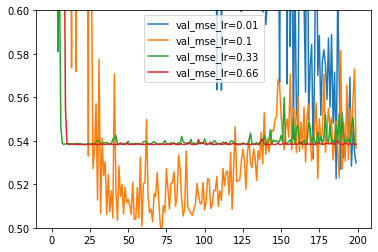

In [49]:
for k,v in NN2_tuning_learning_rate.items():
    pl.plot(v.history['val_loss'],label=f'val_mse_lr={k}')
pl.legend()
pl.ylim(0.5,0.6)

In [50]:
NN2_tuneing_dropout = {}
for droprate in [0.0,0.2,0.4,0.6,0.8]:
    NN2_tuneing_dropout[droprate] = train_NN(df_train,y_train,df_val,y_val
                                           ,inner_layers=best_ddn2_layer_size
                                           ,droprate=droprate
                                           ,learning_rate=best_ddn2_learning_rate
                                           ,input_droprate=best_ddn2_input_droprate)

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_36 (Normaliza  (None, 56)               113       
 tion)                                                           
                                                                 
 dense_76 (Dense)            (None, 16)                912       
                                                                 
 dense_77 (Dense)            (None, 16)                272       
                                                                 
 dense_78 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,314
Trainable params: 1,201
Non-trainable params: 113
_________________________________________________________________
Epoch 1/200
15/15 [==============================] - 1s 12ms/step - loss: 205.1617 - val_loss: 90.7066
Epoch 2/200


15/15 [==============================] - 0s 7ms/step - loss: 0.5026 - val_loss: 0.5462
Epoch 73/200
15/15 [==============================] - 0s 8ms/step - loss: 0.5057 - val_loss: 0.5415
Epoch 74/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5008 - val_loss: 0.5462
Epoch 75/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5029 - val_loss: 0.5451
Epoch 76/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5038 - val_loss: 0.5453
Epoch 77/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5007 - val_loss: 0.5431
Epoch 78/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5017 - val_loss: 0.5421
Epoch 79/200
15/15 [==============================] - 0s 12ms/step - loss: 0.5015 - val_loss: 0.5432
Epoch 80/200
15/15 [==============================] - 0s 11ms/step - loss: 0.5017 - val_loss: 0.5419
Epoch 81/200
15/15 [==============================] - 0s 12ms/step - loss: 0.4978 - val_loss: 0.5465
Epoch 82/2

15/15 [==============================] - 0s 6ms/step - loss: 0.4923 - val_loss: 0.5505
Epoch 154/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4949 - val_loss: 0.5562
Epoch 155/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4955 - val_loss: 0.5493
Epoch 156/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4941 - val_loss: 0.5578
Epoch 157/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4961 - val_loss: 0.5461
Epoch 158/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4954 - val_loss: 0.5542
Epoch 159/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4937 - val_loss: 0.5480
Epoch 160/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4939 - val_loss: 0.5510
Epoch 161/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4930 - val_loss: 0.5492
Epoch 162/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4928 - val_loss: 0.5539
Epoc

15/15 [==============================] - 0s 5ms/step - loss: 0.5220 - val_loss: 0.5383
Epoch 22/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5215 - val_loss: 0.5383
Epoch 23/200
15/15 [==============================] - 0s 5ms/step - loss: 0.5220 - val_loss: 0.5386
Epoch 24/200
15/15 [==============================] - 0s 5ms/step - loss: 0.5223 - val_loss: 0.5384
Epoch 25/200
15/15 [==============================] - 0s 5ms/step - loss: 0.5222 - val_loss: 0.5384
Epoch 26/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5220 - val_loss: 0.5383
Epoch 27/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5219 - val_loss: 0.5383
Epoch 28/200
15/15 [==============================] - 0s 5ms/step - loss: 0.5220 - val_loss: 0.5390
Epoch 29/200
15/15 [==============================] - 0s 5ms/step - loss: 0.5217 - val_loss: 0.5384
Epoch 30/200
15/15 [==============================] - 0s 5ms/step - loss: 0.5222 - val_loss: 0.5383
Epoch 31/200


15/15 [==============================] - 0s 6ms/step - loss: 0.5246 - val_loss: 0.5400
Epoch 104/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5210 - val_loss: 0.5385
Epoch 105/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5287 - val_loss: 0.5383
Epoch 106/200
15/15 [==============================] - 0s 8ms/step - loss: 0.5228 - val_loss: 0.5399
Epoch 107/200
15/15 [==============================] - 0s 8ms/step - loss: 0.5232 - val_loss: 0.5392
Epoch 108/200
15/15 [==============================] - 0s 9ms/step - loss: 0.5242 - val_loss: 0.5384
Epoch 109/200
15/15 [==============================] - 0s 9ms/step - loss: 0.5244 - val_loss: 0.5383
Epoch 110/200
15/15 [==============================] - 0s 11ms/step - loss: 0.5222 - val_loss: 0.5389
Epoch 111/200
15/15 [==============================] - 0s 7ms/step - loss: 0.5247 - val_loss: 0.5384
Epoch 112/200
15/15 [==============================] - 0s 7ms/step - loss: 0.5231 - val_loss: 0.5383
Epo

15/15 [==============================] - 0s 11ms/step - loss: 0.5246 - val_loss: 0.5383
Epoch 185/200
15/15 [==============================] - 0s 10ms/step - loss: 0.5243 - val_loss: 0.5386
Epoch 186/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5260 - val_loss: 0.5399
Epoch 187/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5246 - val_loss: 0.5398
Epoch 188/200
15/15 [==============================] - 0s 10ms/step - loss: 0.5279 - val_loss: 0.5388
Epoch 189/200
15/15 [==============================] - 0s 13ms/step - loss: 0.5215 - val_loss: 0.5411
Epoch 190/200
15/15 [==============================] - 0s 7ms/step - loss: 0.5243 - val_loss: 0.5393
Epoch 191/200
15/15 [==============================] - 0s 7ms/step - loss: 0.5230 - val_loss: 0.5385
Epoch 192/200
15/15 [==============================] - 0s 7ms/step - loss: 0.5303 - val_loss: 0.5386
Epoch 193/200
15/15 [==============================] - 0s 8ms/step - loss: 0.5256 - val_loss: 0.5409


Epoch 53/200
15/15 [==============================] - 0s 13ms/step - loss: 0.5217 - val_loss: 0.5383
Epoch 54/200
15/15 [==============================] - 0s 28ms/step - loss: 0.5218 - val_loss: 0.5384
Epoch 55/200
15/15 [==============================] - 0s 12ms/step - loss: 0.5216 - val_loss: 0.5383
Epoch 56/200
15/15 [==============================] - 0s 10ms/step - loss: 0.5218 - val_loss: 0.5385
Epoch 57/200
15/15 [==============================] - 0s 9ms/step - loss: 0.5216 - val_loss: 0.5384
Epoch 58/200
15/15 [==============================] - 0s 8ms/step - loss: 0.5242 - val_loss: 0.5386
Epoch 59/200
15/15 [==============================] - 0s 8ms/step - loss: 0.5219 - val_loss: 0.5383
Epoch 60/200
15/15 [==============================] - 0s 7ms/step - loss: 0.5226 - val_loss: 0.5389
Epoch 61/200
15/15 [==============================] - 0s 14ms/step - loss: 0.5219 - val_loss: 0.5384
Epoch 62/200
15/15 [==============================] - 0s 9ms/step - loss: 0.5251 - val_loss: 0.

15/15 [==============================] - 0s 21ms/step - loss: 0.5251 - val_loss: 0.5383
Epoch 135/200
15/15 [==============================] - 0s 19ms/step - loss: 0.5213 - val_loss: 0.5386
Epoch 136/200
15/15 [==============================] - 0s 14ms/step - loss: 0.5235 - val_loss: 0.5384
Epoch 137/200
15/15 [==============================] - 0s 9ms/step - loss: 0.5218 - val_loss: 0.5388
Epoch 138/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5224 - val_loss: 0.5389
Epoch 139/200
15/15 [==============================] - 0s 8ms/step - loss: 0.5243 - val_loss: 0.5384
Epoch 140/200
15/15 [==============================] - 0s 7ms/step - loss: 0.5253 - val_loss: 0.5384
Epoch 141/200
15/15 [==============================] - 0s 7ms/step - loss: 0.5242 - val_loss: 0.5386
Epoch 142/200
15/15 [==============================] - 0s 10ms/step - loss: 0.5257 - val_loss: 0.5383
Epoch 143/200
15/15 [==============================] - 0s 9ms/step - loss: 0.5247 - val_loss: 0.5383


15/15 [==============================] - 0s 6ms/step - loss: 137.1102 - val_loss: 37.9642
Epoch 3/200
15/15 [==============================] - 0s 19ms/step - loss: 24.2681 - val_loss: 7.3723
Epoch 4/200
15/15 [==============================] - 0s 8ms/step - loss: 3.3256 - val_loss: 0.8990
Epoch 5/200
15/15 [==============================] - 0s 9ms/step - loss: 0.6182 - val_loss: 0.5700
Epoch 6/200
15/15 [==============================] - 0s 8ms/step - loss: 0.5754 - val_loss: 0.5997
Epoch 7/200
15/15 [==============================] - 0s 8ms/step - loss: 0.5581 - val_loss: 0.5514
Epoch 8/200
15/15 [==============================] - 0s 7ms/step - loss: 0.5299 - val_loss: 0.5383
Epoch 9/200
15/15 [==============================] - 0s 7ms/step - loss: 0.5217 - val_loss: 0.5384
Epoch 10/200
15/15 [==============================] - 0s 7ms/step - loss: 0.5217 - val_loss: 0.5383
Epoch 11/200
15/15 [==============================] - 0s 8ms/step - loss: 0.5215 - val_loss: 0.5383
Epoch 12/200
15

15/15 [==============================] - 0s 6ms/step - loss: 0.5217 - val_loss: 0.5389
Epoch 84/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5235 - val_loss: 0.5384
Epoch 85/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5234 - val_loss: 0.5388
Epoch 86/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5247 - val_loss: 0.5383
Epoch 87/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5278 - val_loss: 0.5384
Epoch 88/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5264 - val_loss: 0.5386
Epoch 89/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5266 - val_loss: 0.5385
Epoch 90/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5263 - val_loss: 0.5385
Epoch 91/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5219 - val_loss: 0.5397
Epoch 92/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5230 - val_loss: 0.5390
Epoch 93/200


15/15 [==============================] - 0s 6ms/step - loss: 0.5292 - val_loss: 0.5403
Epoch 165/200
15/15 [==============================] - 0s 9ms/step - loss: 0.5282 - val_loss: 0.5424
Epoch 166/200
15/15 [==============================] - 0s 10ms/step - loss: 0.5294 - val_loss: 0.5409
Epoch 167/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5253 - val_loss: 0.5394
Epoch 168/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5258 - val_loss: 0.5385
Epoch 169/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5246 - val_loss: 0.5398
Epoch 170/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5249 - val_loss: 0.5385
Epoch 171/200
15/15 [==============================] - 0s 5ms/step - loss: 0.5241 - val_loss: 0.5385
Epoch 172/200
15/15 [==============================] - 0s 5ms/step - loss: 0.5305 - val_loss: 0.5421
Epoch 173/200
15/15 [==============================] - 0s 5ms/step - loss: 0.5276 - val_loss: 0.5383
Epo

Epoch 33/200
15/15 [==============================] - 0s 8ms/step - loss: 0.5248 - val_loss: 0.5384
Epoch 34/200
15/15 [==============================] - 0s 10ms/step - loss: 0.5225 - val_loss: 0.5383
Epoch 35/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5206 - val_loss: 0.5386
Epoch 36/200
15/15 [==============================] - 0s 8ms/step - loss: 0.5214 - val_loss: 0.5384
Epoch 37/200
15/15 [==============================] - 0s 8ms/step - loss: 0.5215 - val_loss: 0.5384
Epoch 38/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5217 - val_loss: 0.5383
Epoch 39/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5245 - val_loss: 0.5383
Epoch 40/200
15/15 [==============================] - 0s 9ms/step - loss: 0.5230 - val_loss: 0.5385
Epoch 41/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5190 - val_loss: 0.5383
Epoch 42/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5217 - val_loss: 0.5384

Epoch 115/200
15/15 [==============================] - 0s 7ms/step - loss: 0.5243 - val_loss: 0.5388
Epoch 116/200
15/15 [==============================] - 0s 7ms/step - loss: 0.5233 - val_loss: 0.5383
Epoch 117/200
15/15 [==============================] - 0s 7ms/step - loss: 0.5216 - val_loss: 0.5383
Epoch 118/200
15/15 [==============================] - 0s 7ms/step - loss: 0.5222 - val_loss: 0.5383
Epoch 119/200
15/15 [==============================] - 0s 7ms/step - loss: 0.5217 - val_loss: 0.5390
Epoch 120/200
15/15 [==============================] - 0s 7ms/step - loss: 0.5240 - val_loss: 0.5383
Epoch 121/200
15/15 [==============================] - 0s 7ms/step - loss: 0.5228 - val_loss: 0.5389
Epoch 122/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5233 - val_loss: 0.5388
Epoch 123/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5243 - val_loss: 0.5384
Epoch 124/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5226 - val_los

15/15 [==============================] - 0s 6ms/step - loss: 0.5283 - val_loss: 0.5399
Epoch 197/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5267 - val_loss: 0.5391
Epoch 198/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5282 - val_loss: 0.5392
Epoch 199/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5335 - val_loss: 0.5425
Epoch 200/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5253 - val_loss: 0.5396


(0.52, 0.56)

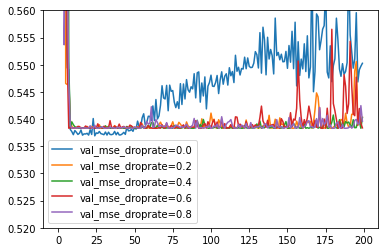

In [51]:
for k,v in NN2_tuneing_dropout.items():
    pl.plot(v.history['val_loss'],label=f'val_mse_droprate={k}')
pl.legend()
pl.ylim(0.52,0.56)

In [52]:
NN2_tuneing_input_dropout = {}
for droprate in [0.0,0.2,0.4,0.6,0.8]:
    NN2_tuneing_input_dropout[droprate] = train_NN(df_train,y_train,df_val,y_val
                                           ,inner_layers=best_ddn2_layer_size
                                           ,droprate=best_ddn2_droprate
                                           ,learning_rate=best_ddn2_learning_rate
                                           ,input_droprate=droprate)

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_41 (Normaliza  (None, 56)               113       
 tion)                                                           
                                                                 
 dense_91 (Dense)            (None, 16)                912       
                                                                 
 dropout_64 (Dropout)        (None, 16)                0         
                                                                 
 dense_92 (Dense)            (None, 16)                272       
                                                                 
 dropout_65 (Dropout)        (None, 16)                0         
                                                                 
 dense_93 (Dense)            (None, 1)                 17        
                                                     

15/15 [==============================] - 0s 6ms/step - loss: 0.5219 - val_loss: 0.5386
Epoch 71/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5228 - val_loss: 0.5384
Epoch 72/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5223 - val_loss: 0.5388
Epoch 73/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5235 - val_loss: 0.5385
Epoch 74/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5232 - val_loss: 0.5383
Epoch 75/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5217 - val_loss: 0.5383
Epoch 76/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5224 - val_loss: 0.5384
Epoch 77/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5222 - val_loss: 0.5389
Epoch 78/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5214 - val_loss: 0.5383
Epoch 79/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5226 - val_loss: 0.5384
Epoch 80/200


15/15 [==============================] - 0s 6ms/step - loss: 0.5228 - val_loss: 0.5383
Epoch 152/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5224 - val_loss: 0.5383
Epoch 153/200
15/15 [==============================] - 0s 7ms/step - loss: 0.5261 - val_loss: 0.5388
Epoch 154/200
15/15 [==============================] - 0s 8ms/step - loss: 0.5290 - val_loss: 0.5408
Epoch 155/200
15/15 [==============================] - 0s 8ms/step - loss: 0.5296 - val_loss: 0.5398
Epoch 156/200
15/15 [==============================] - 0s 17ms/step - loss: 0.5273 - val_loss: 0.5410
Epoch 157/200
15/15 [==============================] - 0s 7ms/step - loss: 0.5237 - val_loss: 0.5385
Epoch 158/200
15/15 [==============================] - 0s 11ms/step - loss: 0.5222 - val_loss: 0.5392
Epoch 159/200
15/15 [==============================] - 0s 9ms/step - loss: 0.5256 - val_loss: 0.5396
Epoch 160/200
15/15 [==============================] - 0s 9ms/step - loss: 0.5240 - val_loss: 0.5392
Ep

15/15 [==============================] - 0s 6ms/step - loss: 0.5216 - val_loss: 0.5384
Epoch 19/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5215 - val_loss: 0.5383
Epoch 20/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5216 - val_loss: 0.5383
Epoch 21/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5218 - val_loss: 0.5383
Epoch 22/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5218 - val_loss: 0.5383
Epoch 23/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5215 - val_loss: 0.5385
Epoch 24/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5218 - val_loss: 0.5383
Epoch 25/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5216 - val_loss: 0.5384
Epoch 26/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5226 - val_loss: 0.5383
Epoch 27/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5221 - val_loss: 0.5387
Epoch 28/200


15/15 [==============================] - 0s 6ms/step - loss: 0.5231 - val_loss: 0.5385
Epoch 101/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5224 - val_loss: 0.5383
Epoch 102/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5230 - val_loss: 0.5383
Epoch 103/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5232 - val_loss: 0.5409
Epoch 104/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5246 - val_loss: 0.5390
Epoch 105/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5225 - val_loss: 0.5383
Epoch 106/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5236 - val_loss: 0.5403
Epoch 107/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5231 - val_loss: 0.5384
Epoch 108/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5220 - val_loss: 0.5383
Epoch 109/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5233 - val_loss: 0.5386
Epoc

15/15 [==============================] - 0s 7ms/step - loss: 0.5270 - val_loss: 0.5401
Epoch 182/200
15/15 [==============================] - 0s 8ms/step - loss: 0.5256 - val_loss: 0.5400
Epoch 183/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5278 - val_loss: 0.5384
Epoch 184/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5274 - val_loss: 0.5427
Epoch 185/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5273 - val_loss: 0.5384
Epoch 186/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5232 - val_loss: 0.5385
Epoch 187/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5246 - val_loss: 0.5400
Epoch 188/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5225 - val_loss: 0.5406
Epoch 189/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5230 - val_loss: 0.5384
Epoch 190/200
15/15 [==============================] - 0s 7ms/step - loss: 0.5244 - val_loss: 0.5385
Epoc

15/15 [==============================] - 0s 6ms/step - loss: 0.5227 - val_loss: 0.5383
Epoch 49/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5194 - val_loss: 0.5386
Epoch 50/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5248 - val_loss: 0.5386
Epoch 51/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5231 - val_loss: 0.5385
Epoch 52/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5225 - val_loss: 0.5384
Epoch 53/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5224 - val_loss: 0.5401
Epoch 54/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5220 - val_loss: 0.5383
Epoch 55/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5251 - val_loss: 0.5383
Epoch 56/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5216 - val_loss: 0.5383
Epoch 57/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5227 - val_loss: 0.5384
Epoch 58/200


15/15 [==============================] - 0s 5ms/step - loss: 0.5249 - val_loss: 0.5392
Epoch 130/200
15/15 [==============================] - 0s 5ms/step - loss: 0.5252 - val_loss: 0.5400
Epoch 131/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5246 - val_loss: 0.5383
Epoch 132/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5242 - val_loss: 0.5384
Epoch 133/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5233 - val_loss: 0.5401
Epoch 134/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5329 - val_loss: 0.5390
Epoch 135/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5260 - val_loss: 0.5384
Epoch 136/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5223 - val_loss: 0.5385
Epoch 137/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5222 - val_loss: 0.5385
Epoch 138/200
15/15 [==============================] - 0s 5ms/step - loss: 0.5249 - val_loss: 0.5383
Epoc

15/15 [==============================] - 1s 13ms/step - loss: 259.4579 - val_loss: 122.3065
Epoch 2/200
15/15 [==============================] - 0s 6ms/step - loss: 85.0308 - val_loss: 48.0722
Epoch 3/200
15/15 [==============================] - 0s 5ms/step - loss: 28.9694 - val_loss: 12.9263
Epoch 4/200
15/15 [==============================] - 0s 6ms/step - loss: 6.7182 - val_loss: 2.2686
Epoch 5/200
15/15 [==============================] - 0s 5ms/step - loss: 1.1511 - val_loss: 0.5854
Epoch 6/200
15/15 [==============================] - 0s 5ms/step - loss: 0.5309 - val_loss: 0.5577
Epoch 7/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5432 - val_loss: 0.5607
Epoch 8/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5341 - val_loss: 0.5426
Epoch 9/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5234 - val_loss: 0.5384
Epoch 10/200
15/15 [==============================] - 0s 5ms/step - loss: 0.5214 - val_loss: 0.5383
Epoch 11/200

Epoch 83/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5220 - val_loss: 0.5383
Epoch 84/200
15/15 [==============================] - 0s 9ms/step - loss: 0.5220 - val_loss: 0.5386
Epoch 85/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5221 - val_loss: 0.5387
Epoch 86/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5246 - val_loss: 0.5387
Epoch 87/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5231 - val_loss: 0.5384
Epoch 88/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5227 - val_loss: 0.5384
Epoch 89/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5215 - val_loss: 0.5394
Epoch 90/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5232 - val_loss: 0.5386
Epoch 91/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5225 - val_loss: 0.5385
Epoch 92/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5233 - val_loss: 0.5383


15/15 [==============================] - 0s 6ms/step - loss: 0.5256 - val_loss: 0.5433
Epoch 165/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5332 - val_loss: 0.5403
Epoch 166/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5243 - val_loss: 0.5383
Epoch 167/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5247 - val_loss: 0.5411
Epoch 168/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5257 - val_loss: 0.5384
Epoch 169/200
15/15 [==============================] - 0s 9ms/step - loss: 0.5253 - val_loss: 0.5402
Epoch 170/200
15/15 [==============================] - 0s 8ms/step - loss: 0.5229 - val_loss: 0.5383
Epoch 171/200
15/15 [==============================] - 0s 7ms/step - loss: 0.5227 - val_loss: 0.5386
Epoch 172/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5297 - val_loss: 0.5434
Epoch 173/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5296 - val_loss: 0.5383
Epoc

15/15 [==============================] - 0s 6ms/step - loss: 0.5226 - val_loss: 0.5385
Epoch 32/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5216 - val_loss: 0.5383
Epoch 33/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5217 - val_loss: 0.5384
Epoch 34/200
15/15 [==============================] - 0s 12ms/step - loss: 0.5216 - val_loss: 0.5384
Epoch 35/200
15/15 [==============================] - 0s 7ms/step - loss: 0.5215 - val_loss: 0.5383
Epoch 36/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5223 - val_loss: 0.5384
Epoch 37/200
15/15 [==============================] - 0s 7ms/step - loss: 0.5214 - val_loss: 0.5383
Epoch 38/200
15/15 [==============================] - 0s 10ms/step - loss: 0.5228 - val_loss: 0.5384
Epoch 39/200
15/15 [==============================] - 0s 10ms/step - loss: 0.5226 - val_loss: 0.5388
Epoch 40/200
15/15 [==============================] - 0s 7ms/step - loss: 0.5222 - val_loss: 0.5383
Epoch 41/2

Epoch 113/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5349 - val_loss: 0.5393
Epoch 114/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5227 - val_loss: 0.5428
Epoch 115/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5268 - val_loss: 0.5395
Epoch 116/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5231 - val_loss: 0.5389
Epoch 117/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5229 - val_loss: 0.5383
Epoch 118/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5227 - val_loss: 0.5384
Epoch 119/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5229 - val_loss: 0.5384
Epoch 120/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5226 - val_loss: 0.5386
Epoch 121/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5238 - val_loss: 0.5392
Epoch 122/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5243 - val_los

15/15 [==============================] - 0s 6ms/step - loss: 0.5234 - val_loss: 0.5386
Epoch 195/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5234 - val_loss: 0.5387
Epoch 196/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5224 - val_loss: 0.5383
Epoch 197/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5230 - val_loss: 0.5383
Epoch 198/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5270 - val_loss: 0.5390
Epoch 199/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5246 - val_loss: 0.5393
Epoch 200/200
15/15 [==============================] - 0s 7ms/step - loss: 0.5305 - val_loss: 0.5393


(0.5, 0.7)

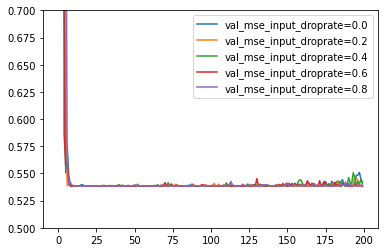

In [53]:
for k,v in NN2_tuneing_input_dropout.items():
    pl.plot(v.history['val_loss'],label=f'val_mse_input_droprate={k}')
pl.legend()
pl.ylim(0.5,0.7)

## Model Comparison

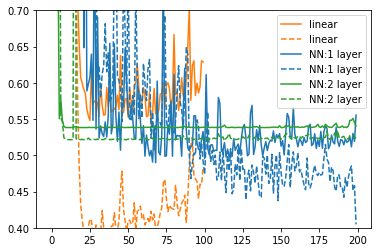

In [54]:
pl.plot(linear_models[0.1].history['val_loss'],color='tab:orange',label='linear')
pl.plot(linear_models[0.1].history['loss'],'--',color='tab:orange',label='linear')

pl.plot(NN_tuneing_input_dropout[best_input_droprate].history['val_loss'],color='tab:blue',label='NN:1 layer')
pl.plot(NN_tuneing_input_dropout[best_input_droprate].history['loss'],'--',color='tab:blue',label='NN:1 layer')

pl.plot(NN2_tuneing_input_dropout[best_ddn2_input_droprate].history['val_loss'],color='tab:green',label='NN:2 layer')
pl.plot(NN2_tuneing_input_dropout[best_ddn2_input_droprate].history['loss'],'--',color='tab:green',label='NN:2 layer')


pl.ylim(0.4,0.7)
pl.legend()

Pick the two layer neural net because the overfitting is not as bad.

# Training Final Model

In [57]:
best = train_NN(df_full_train,y_full_train,df_test,y_test
               ,inner_layers=best_ddn2_layer_size
               ,droprate=best_ddn2_droprate
               ,learning_rate=best_ddn2_learning_rate
               ,input_droprate=best_ddn2_input_droprate)

Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_46 (Normaliza  (None, 56)               113       
 tion)                                                           
                                                                 
 dense_106 (Dense)           (None, 16)                912       
                                                                 
 dropout_78 (Dropout)        (None, 16)                0         
                                                                 
 dense_107 (Dense)           (None, 16)                272       
                                                                 
 dropout_79 (Dropout)        (None, 16)                0         
                                                                 
 dense_108 (Dense)           (None, 1)                 17        
                                                     

60/60 [==============================] - 0s 3ms/step - loss: 0.5500 - val_loss: 0.5493
Epoch 71/200
60/60 [==============================] - 0s 2ms/step - loss: 0.5390 - val_loss: 0.5492
Epoch 72/200
60/60 [==============================] - 0s 3ms/step - loss: 0.5428 - val_loss: 0.5768
Epoch 73/200
60/60 [==============================] - 0s 3ms/step - loss: 0.5456 - val_loss: 0.6102
Epoch 74/200
60/60 [==============================] - 0s 2ms/step - loss: 0.5782 - val_loss: 0.5560
Epoch 75/200
60/60 [==============================] - 0s 2ms/step - loss: 0.5456 - val_loss: 0.5660
Epoch 76/200
60/60 [==============================] - 0s 3ms/step - loss: 0.5542 - val_loss: 0.5492
Epoch 77/200
60/60 [==============================] - 0s 3ms/step - loss: 0.5545 - val_loss: 0.5523
Epoch 78/200
60/60 [==============================] - 0s 2ms/step - loss: 0.5460 - val_loss: 0.5706
Epoch 79/200
60/60 [==============================] - 0s 3ms/step - loss: 0.5611 - val_loss: 0.5480
Epoch 80/200


60/60 [==============================] - 0s 3ms/step - loss: 0.5643 - val_loss: 0.5807
Epoch 152/200
60/60 [==============================] - 0s 2ms/step - loss: 0.5570 - val_loss: 0.6063
Epoch 153/200
60/60 [==============================] - 0s 2ms/step - loss: 0.5590 - val_loss: 0.5480
Epoch 154/200
60/60 [==============================] - 0s 3ms/step - loss: 0.5458 - val_loss: 0.5663
Epoch 155/200
60/60 [==============================] - 0s 3ms/step - loss: 0.5406 - val_loss: 0.5515
Epoch 156/200
60/60 [==============================] - 0s 2ms/step - loss: 0.5509 - val_loss: 0.5551
Epoch 157/200
60/60 [==============================] - 0s 2ms/step - loss: 0.5420 - val_loss: 0.5495
Epoch 158/200
60/60 [==============================] - 0s 3ms/step - loss: 0.5625 - val_loss: 0.6194
Epoch 159/200
60/60 [==============================] - 0s 3ms/step - loss: 0.5544 - val_loss: 0.5483
Epoch 160/200
60/60 [==============================] - 0s 3ms/step - loss: 0.5496 - val_loss: 0.6142
Epoc

(0.5, 0.6)

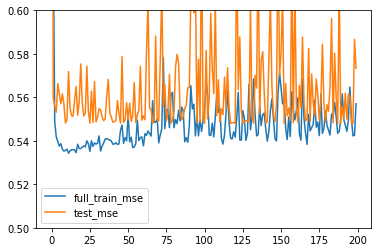

In [60]:
pl.plot(best.history['loss']    ,label='full_train_mse')
pl.plot(best.history['val_loss'],label='test_mse')
pl.legend()
pl.ylim(0.5,0.6)

## Save Model

In [68]:
df[numerical_columns].columns

Index(['duration', 'views', 'unique_words', 'year_published',
       'month_published', 'num_one', 'num_people', 'num_now', 'num_know',
       'num_going', 'num_think', 'num_see', 'num_us', 'num_really', 'num_time',
       'num_world', 'num_will', 'num_actually', 'num_way', 'num_years',
       'num_things', 'num_want', 'num_go', 'num_make', 'num_well', 'num_right',
       'num_said', 'num_first', 'num_something', 'num_much', 'num_two',
       'num_look', 'num_new', 'num_even', 'num_thing', 'num_got', 'num_little',
       'num_say', 'num_back', 'num_work', 'num_many', 'num_life', 'num_need',
       'num_take', 'num_lot', 'num_every', 'num_around', 'num_good',
       'num_kind', 'num_different', 'num_come', 'num_use', 'num_day',
       'num_put', 'num_three', 'times_laughter', 'times_applause'],
      dtype='object')

In [92]:
#best.model.save('keras_model')
tf.saved_model.save(best.model, 'view-model')
model_spec = { 'columns': list(filter(lambda x: x != 'views',df[numerical_columns].columns.to_list())),
               'trained_words': word_counts.head(n=n_words_analyse).keys().to_list(),
               'trained_emotes': emote_counts.head(n=n_emotes_analyse).keys().to_list()}

open('keras_model_spec.json','w+').write(json.dumps(model_spec))

INFO:tensorflow:Assets written to: keras_model/assets
INFO:tensorflow:Assets written to: view-model/assets


1211

## Use model to predict

In [88]:
test = { 'duration':'0:15:00', 'date_published':'01/01/2017', 'transcript':df['transcript'][0] }

def translate_dict(d):
    emotes, words = transcript_to_tokens(d['transcript'])
    d['words'] = words
    d['emotes'] = emotes
    d['unique_words'] = word_count(words)
    df = pd.DataFrame([d])
    df['duration'] = pd.to_timedelta(df['duration']).dt.total_seconds()
    df['date_published'] = pd.to_datetime(df['date_published'])
    df['year_published'] = df['date_published'].dt.year
    df['month_published'] = df['date_published'].dt.month  
    
    for word in model_spec['trained_words']:
        df[f'num_{word}'] = df['words'].apply(lambda xs: xs.count(word))

    for emote in model_spec['trained_emotes']:
        df[f'times_{emote}'] = df['emotes'].apply(lambda xs: xs.count(emote))
    return df
   
test_df = translate_dict(test)[model_spec['columns']]

In [91]:
np.expm1(best.model.predict(test_df))

array([[1491402.4]], dtype=float32)